### **Nithyashree Manohar**
### **nithyash@usc.edu**

In [ ]:
!pip install statsmodels==0.12.1
!pip install pmdarima 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

### **Importing libraries**

In [ ]:
#necessary imports 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from datetime import date, timedelta
from pmdarima.arima import ADFTest
from sklearn import preprocessing
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.api as sm
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

### **Data Preprocessing** 

In [ ]:
#reading csv 
daily_percipitation = pd.read_csv("/content/gdrive/MyDrive/gro_homework/Daily Precipitation.csv")
daily_soil_moisture = pd.read_csv("/content/gdrive/MyDrive/gro_homework/Daily Soil Mositure.csv")
daily_temperature = pd.read_csv("/content/gdrive/MyDrive/gro_homework/Daily Temperature.csv")
eight_day_NDVI = pd.read_csv("/content/gdrive/MyDrive/gro_homework/Eight Day NDVI.csv")
production_quantity = pd.read_csv("/content/gdrive/MyDrive/gro_homework/Production Quantity.csv")
predicted_production_quantity = pd.read_csv("/content/gdrive/MyDrive/gro_homework/predicted_production_qty.csv")

In [ ]:
#changing timestamp to datetime format 
df=[daily_percipitation, daily_soil_moisture, daily_temperature, eight_day_NDVI, production_quantity ]
for x in df:
    x.loc[:,"start_date"]=pd.to_datetime(x.loc[:,"start_date"])
    x.loc[:,"end_date"]=pd.to_datetime(x.loc[:,"end_date"])

In [ ]:
#converting NVDI monthy data to daily data 
NDVI_region = []
NDVI_date = []
NDVI = []
for i in range(len(eight_day_NDVI)):
    start_date = eight_day_NDVI.iloc[i][0]
    end_date = eight_day_NDVI.iloc[i][1]
    delta = end_date - start_date 

    for j in range(delta.days + 1):
        NDVI_date.append(start_date + timedelta(days=j))

        NDVI.append(eight_day_NDVI.iloc[i][2])
        NDVI_region.append(eight_day_NDVI.iloc[i][3])

ndvi=list(zip(NDVI_date,NDVI,NDVI_region))
ndvi_2021=pd.DataFrame(ndvi, columns=['start_date','ndvi','region_id'])
ndvi=ndvi_2021.loc[(ndvi_2021.start_date >='2015') & (ndvi_2021.start_date < '2021')]
ndvi.reset_index(drop=True, inplace=True)

In [ ]:
#dropping rows before 2014 and after 2021
data=[daily_percipitation, daily_soil_moisture, daily_temperature ]
for idx, x in enumerate(data):
    x.drop(['end_date'], axis = 1,inplace=True)

daily_percip=daily_percipitation.loc[(daily_percipitation.start_date >='2015') & (daily_percipitation.start_date < '2021')]
daily_smos=daily_soil_moisture.loc[(daily_soil_moisture.start_date >='2015') & (daily_soil_moisture.start_date < '2021')]
daily_temp=daily_temperature.loc[(daily_temperature.start_date >='2015') & (daily_temperature.start_date < '2021')]

In [ ]:
def merge(daily_percip,daily_smos,daily_temp,ndvi):

    #grouping data by region ID 
    precip = daily_percip.groupby('region_id')
    moisture = daily_smos.groupby('region_id')
    temp = daily_temp.groupby('region_id')
    ndvi_= ndvi.groupby('region_id')

    #resampling daily data to weekly and merging 
    keys=precip.groups.keys()
    df_merged=[]

    for j in keys:
        groups=[]
        a=precip.get_group(j)
        b=moisture.get_group(j)
        c=temp.get_group(j)
        d=ndvi_.get_group(j)

        groups=[a,b,c,d]

        for idx,x in enumerate(groups):
            x.set_index('start_date',inplace=True)
            groups[idx]=x.resample('M').mean()
            # print(len(groups[idx]))
            
            if groups[idx].isna().any().any():
                groups[idx].fillna(value=groups[idx].mean(), inplace=True)

        df_merged.append(reduce(lambda  left,right: pd.merge(left,right,on=['start_date'],
                                                how='outer'), groups))
        
    # renaming and dropping duplicate columns 
    for idx in df_merged:
        idx.reset_index(drop=False,inplace=True)
        idx.columns=['end_date','precip','region_id','smos','region_id_1','temp','region_id_2','ndvi','region_id_3']
        idx.drop(['region_id_1','region_id_2','region_id_3'], axis=1, inplace=True)

        if idx.isna().any().any():
            print("null values found")

    return df_merged 

df_merged=merge(daily_percip,daily_smos,daily_temp,ndvi)

In [ ]:
df_merged[0].head()

end_date     precip  region_id      smos       temp  \
0 2015-01-31 00:00:00+00:00   4.394452       93.0  0.318552  25.003593   
1 2015-02-28 00:00:00+00:00   1.206137       93.0  0.291452  26.807568   
2 2015-03-31 00:00:00+00:00   3.454652       93.0  0.251969  26.954109   
3 2015-04-30 00:00:00+00:00  10.466472       93.0  0.248915  26.948865   
4 2015-05-31 00:00:00+00:00   9.007986       93.0  0.280602  25.405121   

       ndvi  
0  0.760678  
1  0.762225  
2  0.745436  
3  0.784690  
4  0.805188

In [ ]:
#grouping target variable by region
production_quantity_ = production_quantity.groupby('region_id')
keys=production_quantity_.groups.keys()
group_target =[]

for j in keys:
    x=production_quantity_.get_group(j)
    group_target.append(x)

group_target[0].head()

start_date                  end_date    prod  region_id
0 2015-01-01 00:00:00+00:00 2015-01-31 00:00:00+00:00  171725         93
1 2015-02-01 00:00:00+00:00 2015-02-28 00:00:00+00:00  188325         93
2 2015-03-01 00:00:00+00:00 2015-03-31 00:00:00+00:00  247856         93
3 2015-04-01 00:00:00+00:00 2015-04-30 00:00:00+00:00  282791         93
4 2015-05-01 00:00:00+00:00 2015-05-31 00:00:00+00:00  291057         93

In [ ]:
#merging the data with target variable 
new_df=[]
for idx in range(len(df_merged)):
    new_df.append(pd.merge(df_merged[idx], group_target[idx],  how='outer', 
                      left_on=['end_date','region_id'], 
                       right_on = ['end_date','region_id']))
    
new_df[0].head()

end_date     precip  region_id      smos       temp  \
0 2015-01-31 00:00:00+00:00   4.394452       93.0  0.318552  25.003593   
1 2015-02-28 00:00:00+00:00   1.206137       93.0  0.291452  26.807568   
2 2015-03-31 00:00:00+00:00   3.454652       93.0  0.251969  26.954109   
3 2015-04-30 00:00:00+00:00  10.466472       93.0  0.248915  26.948865   
4 2015-05-31 00:00:00+00:00   9.007986       93.0  0.280602  25.405121   

       ndvi                start_date    prod  
0  0.760678 2015-01-01 00:00:00+00:00  171725  
1  0.762225 2015-02-01 00:00:00+00:00  188325  
2  0.745436 2015-03-01 00:00:00+00:00  247856  
3  0.784690 2015-04-01 00:00:00+00:00  282791  
4  0.805188 2015-05-01 00:00:00+00:00  291057

### **Exploratory Data Analysis (EDA)**

In [ ]:
def plot(df,title):
    plt.figure(figsize=(16,5), dpi=100)
    plt.gca().set(title=title, xlabel="Date", ylabel="Value")
    plt.plot(df['start_date'],df['precip'],color='orange')
    plt.plot(df['start_date'],df['smos'],color='blue')
    plt.plot(df['start_date'],df['temp'],color='green')
    plt.plot(df['start_date'],df['ndvi'],color='yellow')
    plt.show()

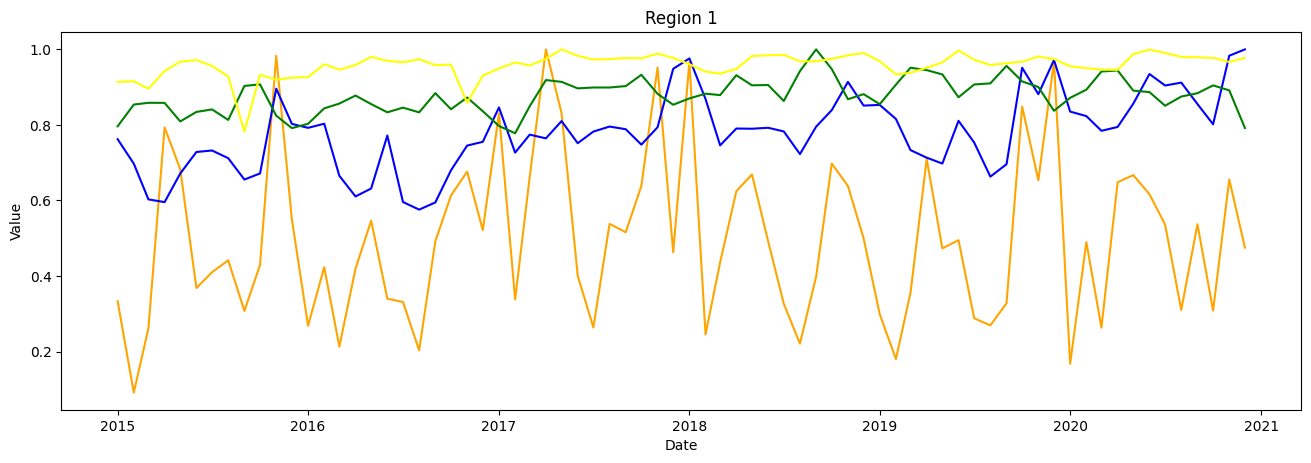

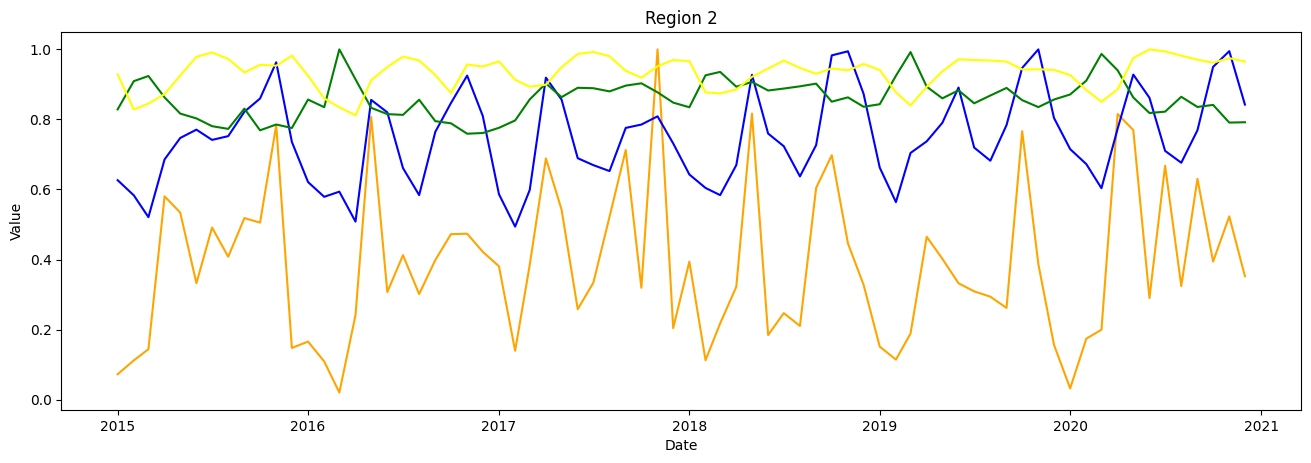

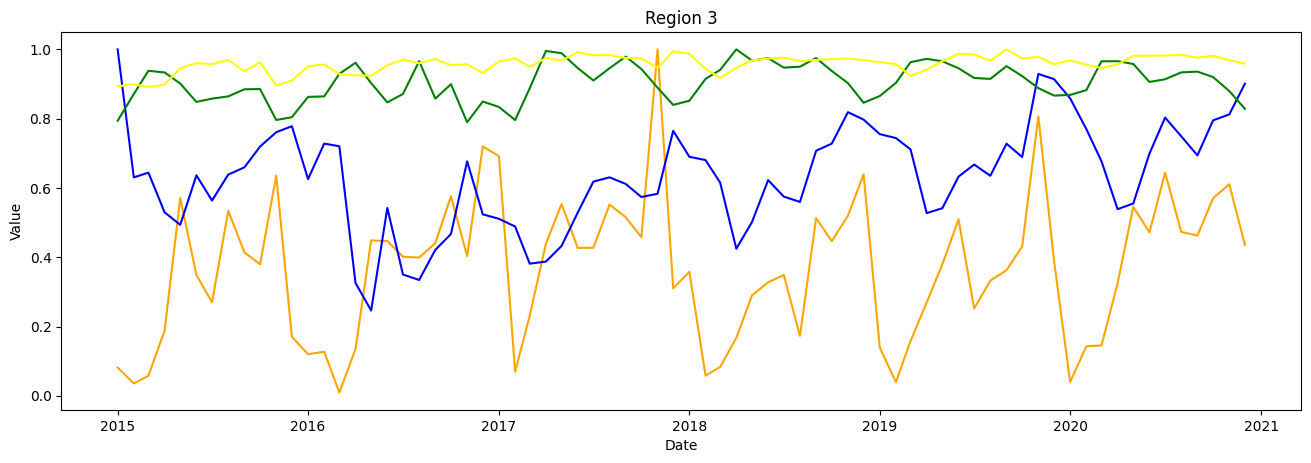

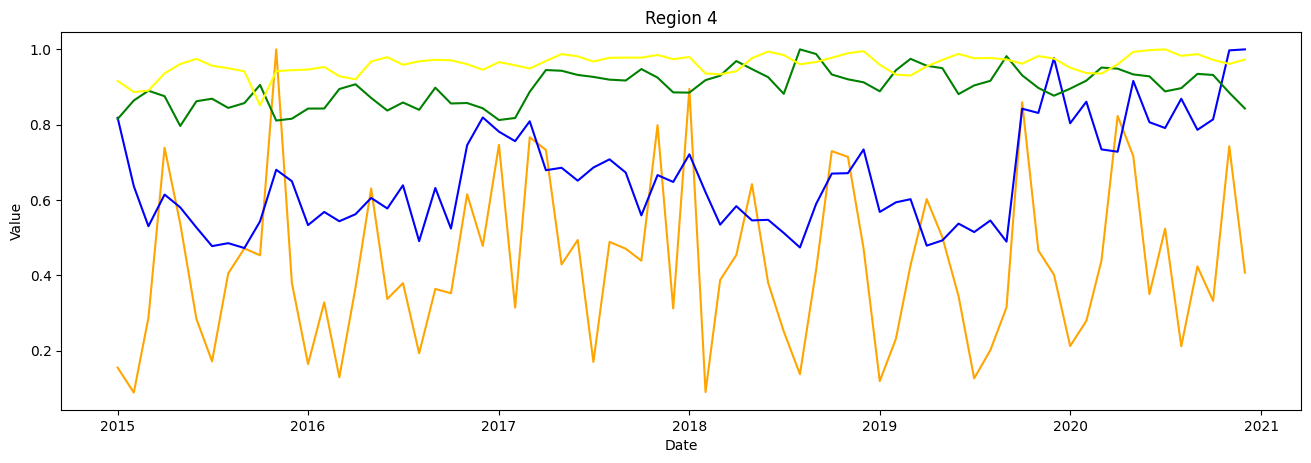

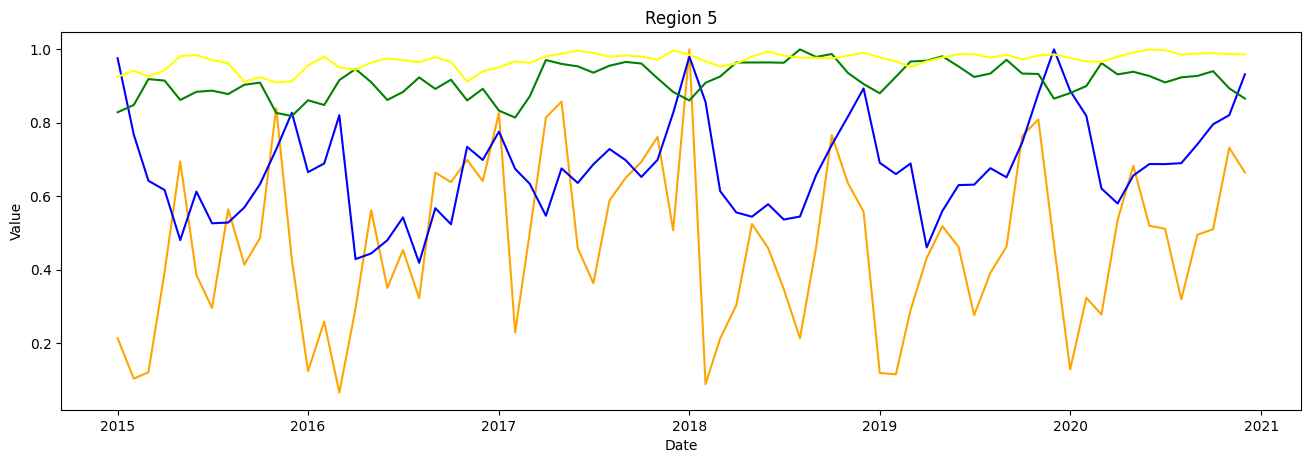

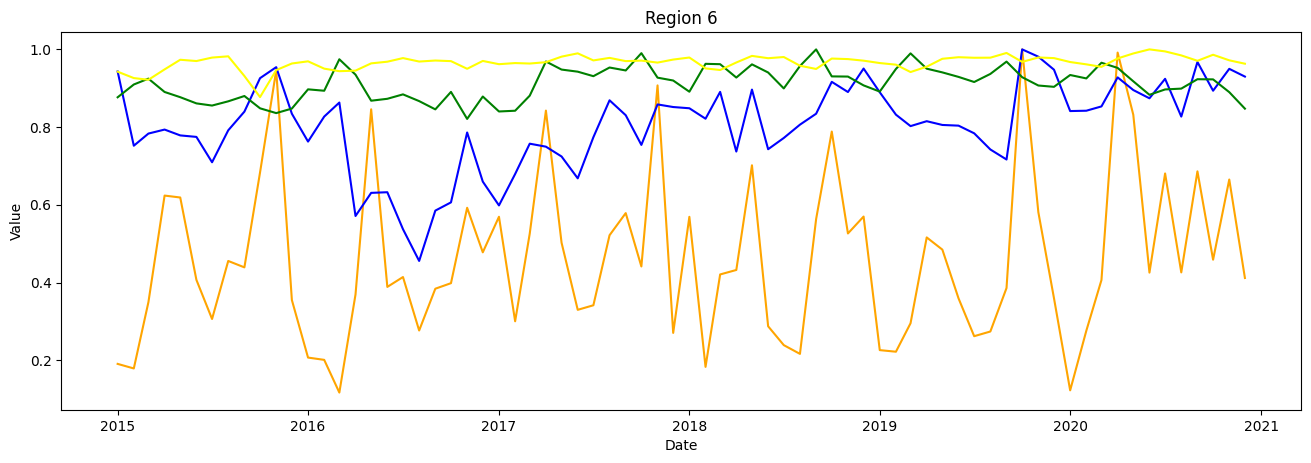

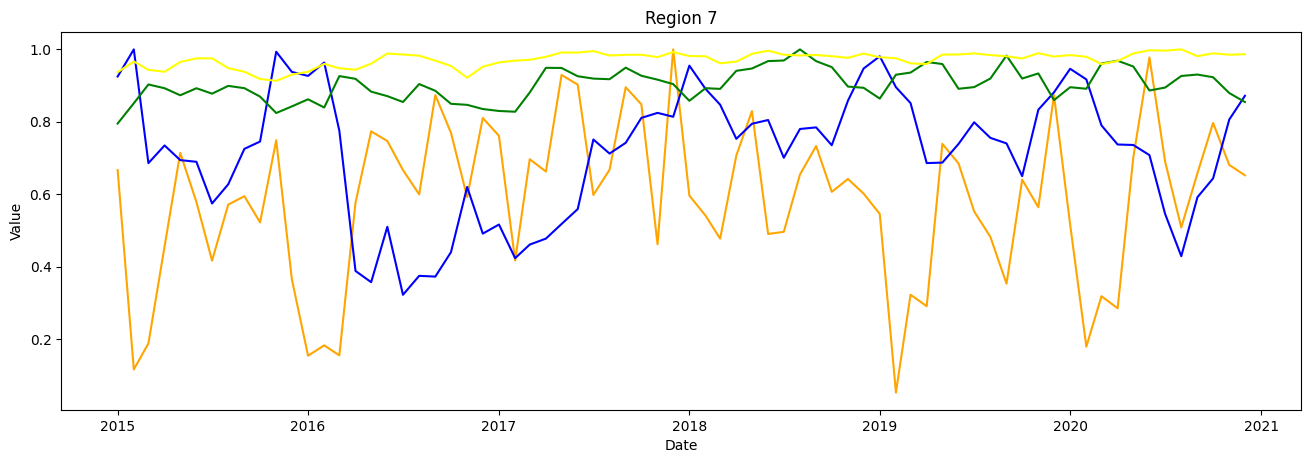

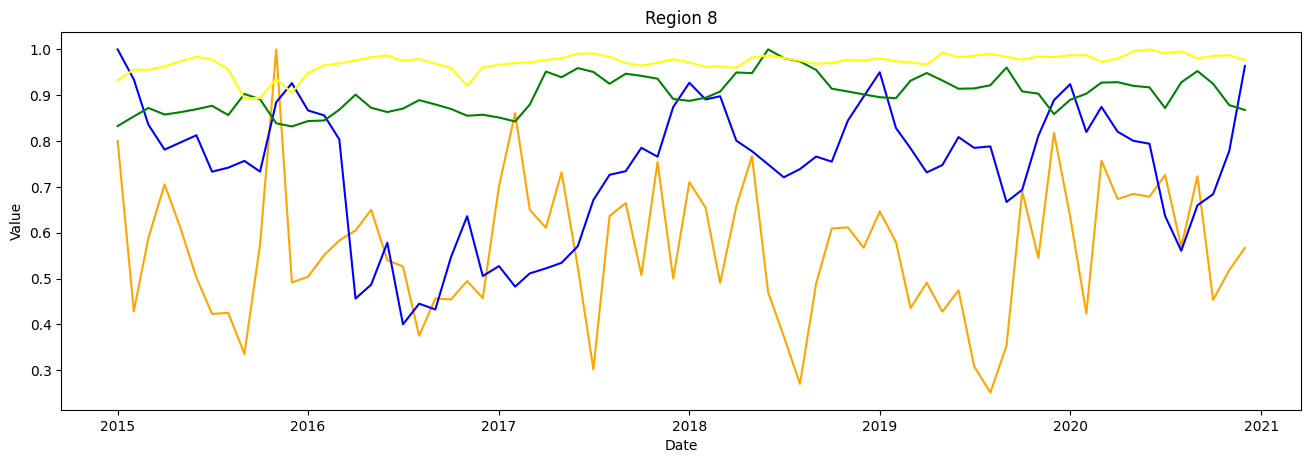

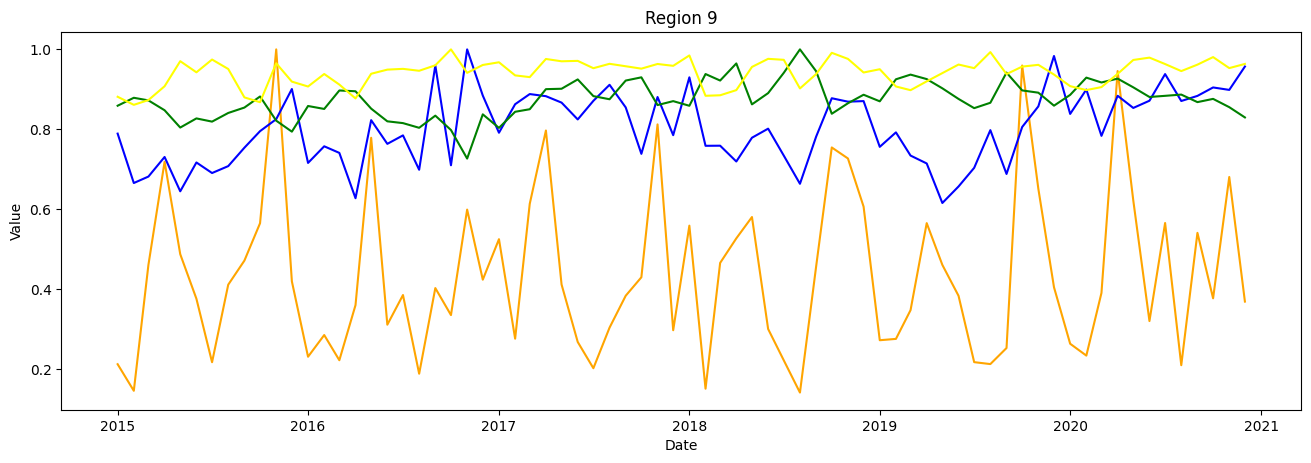

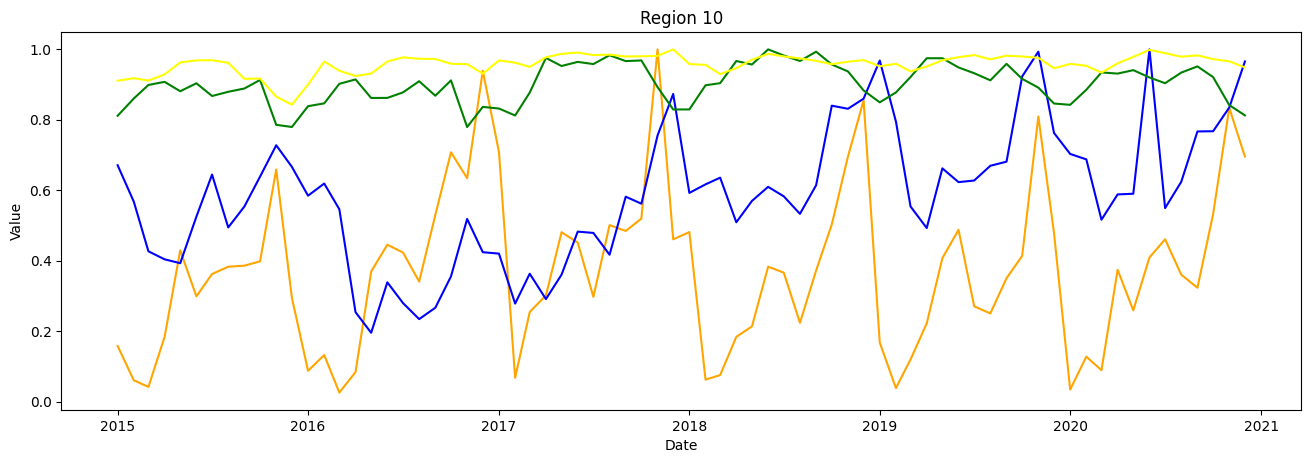

In [ ]:
cols=['precip','smos','temp','ndvi']
for i, x in enumerate(new_df):
    x_copy = x.copy()
    for column in cols:
        x_copy[column] = x_copy[column]  / x_copy[column].abs().max()

    plot(x_copy,"Region "+ str(i+1))

### **Decomposing the time series**

In [ ]:
for x in new_df:  
    x.set_index('start_date',inplace=True)

def decompose(new_df, col):
    for x in new_df:  
        stl = STL(x[col], seasonal=13, period=12)
        res = stl.fit()
        fig, ax = plt.subplots(3,1, figsize=(12,6))
        res.trend.plot(title='Trend', ax=ax[0])
        res.seasonal.plot(title='Seasonal', ax=ax[1])
        res.resid.plot(title='Residual', ax=ax[2])
        plt.tight_layout()
        plt.show()

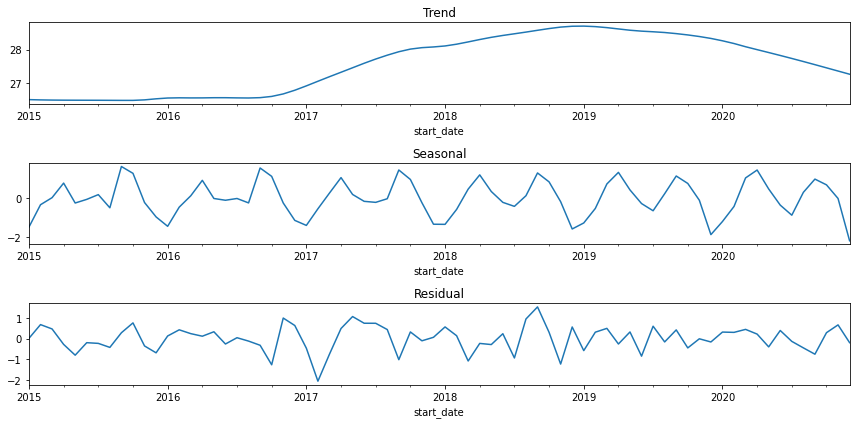

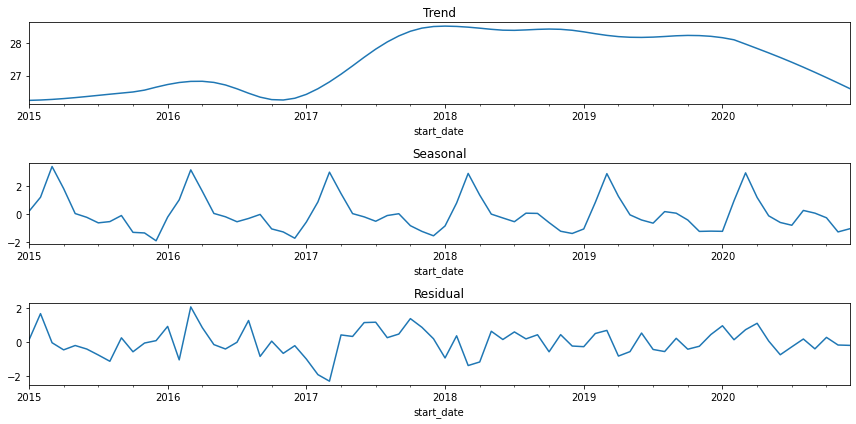

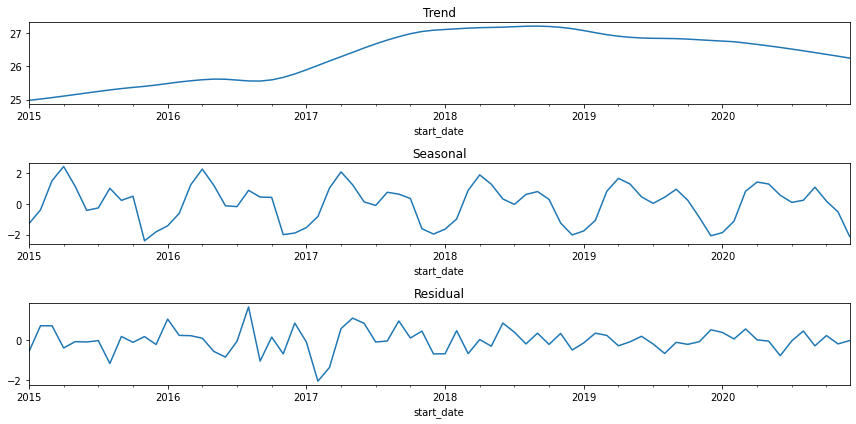

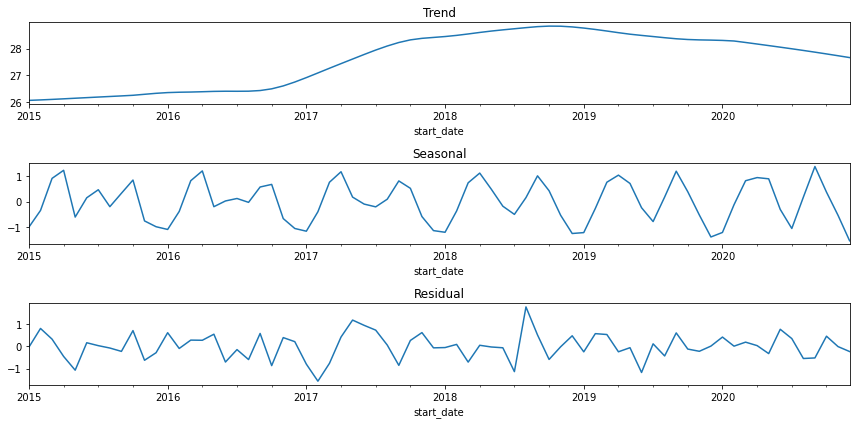

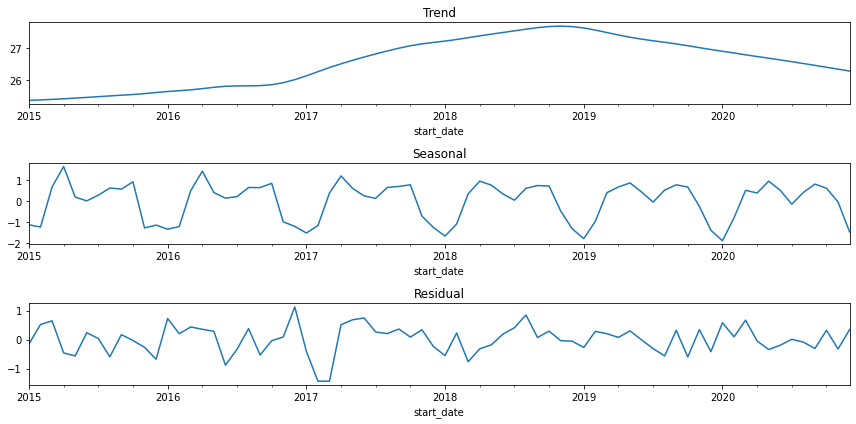

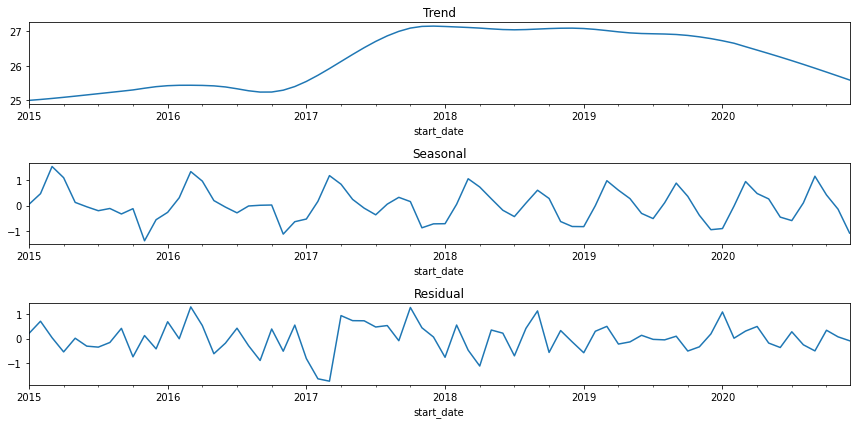

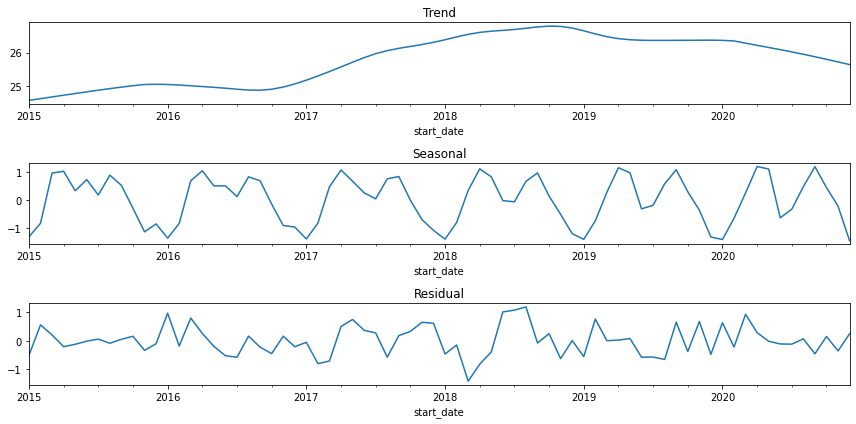

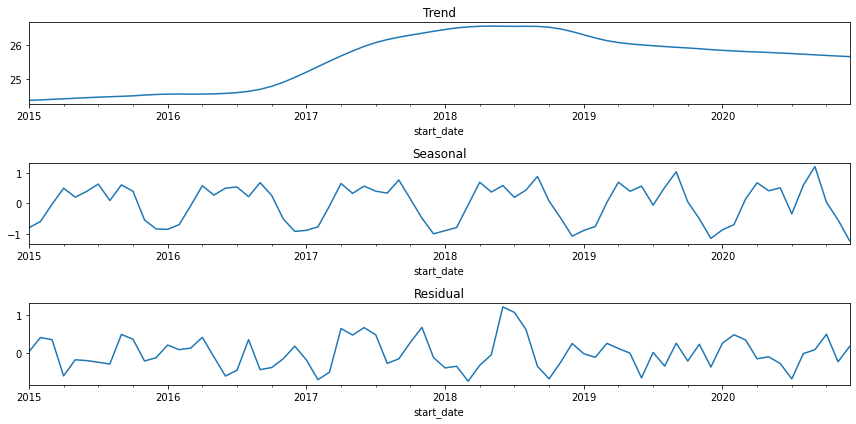

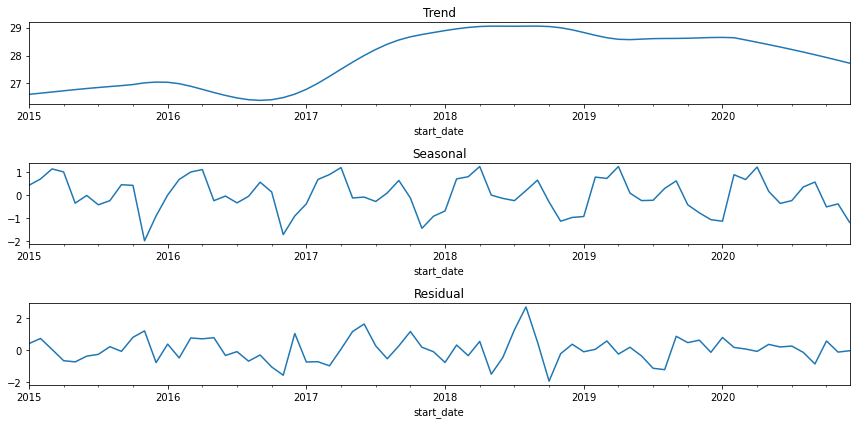

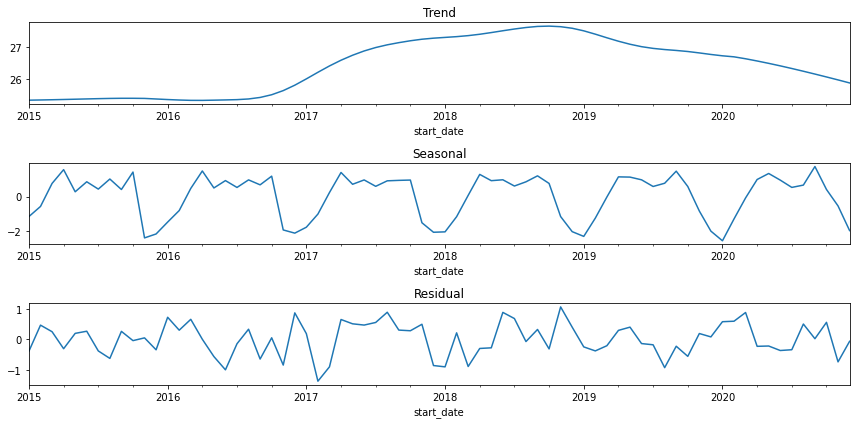

In [ ]:
decompose(new_df, 'temp')

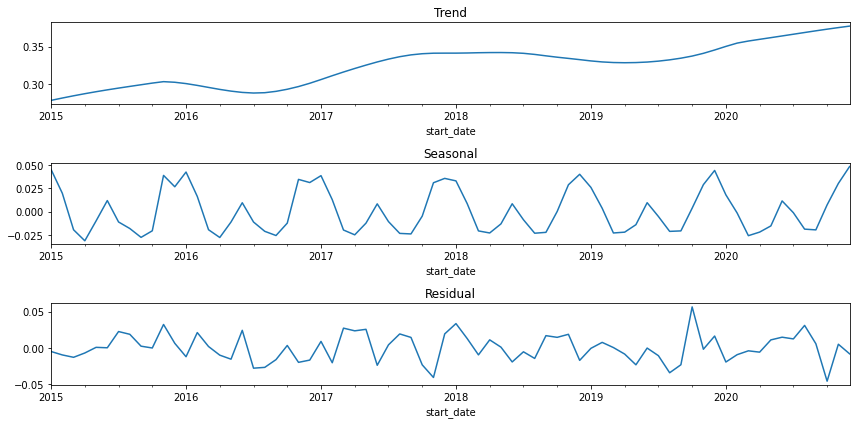

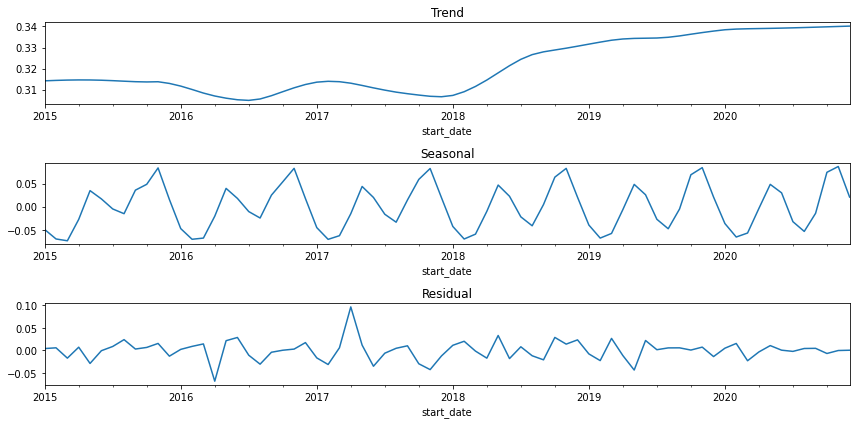

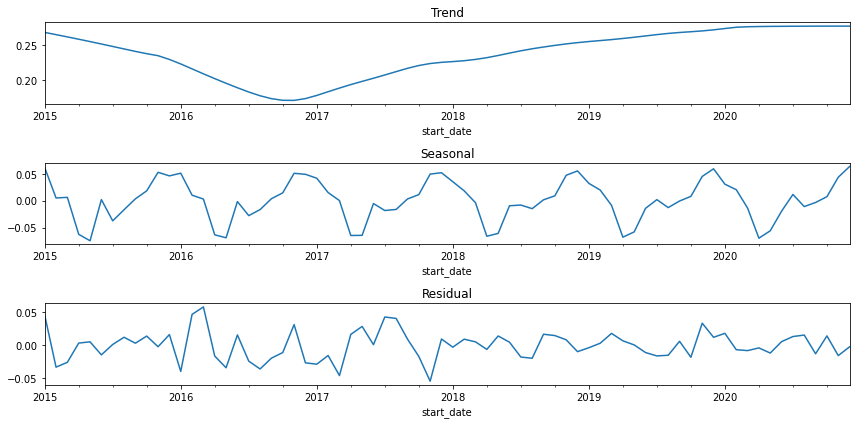

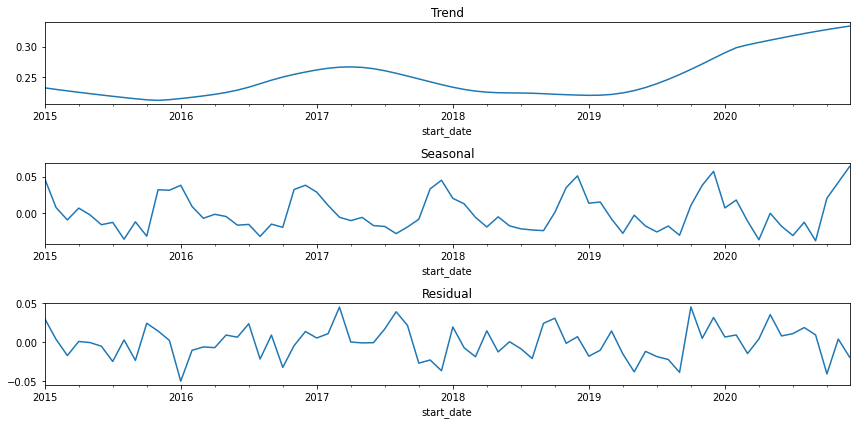

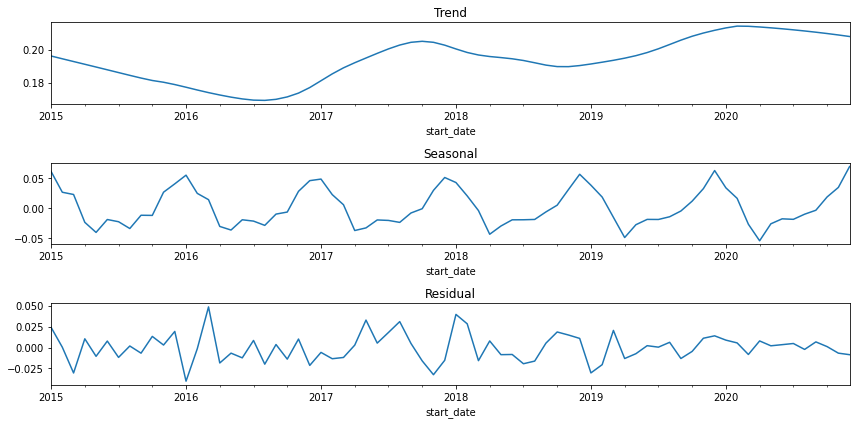

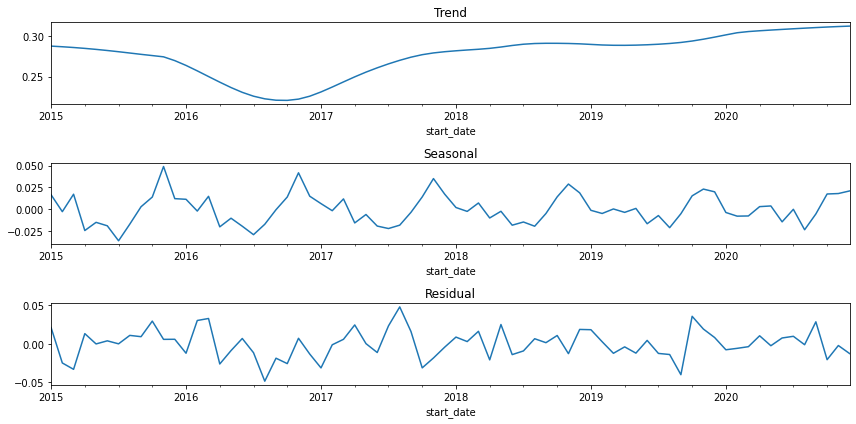

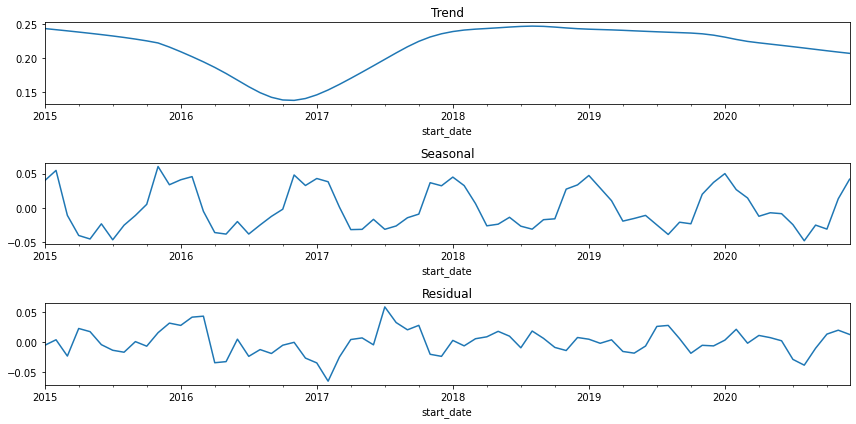

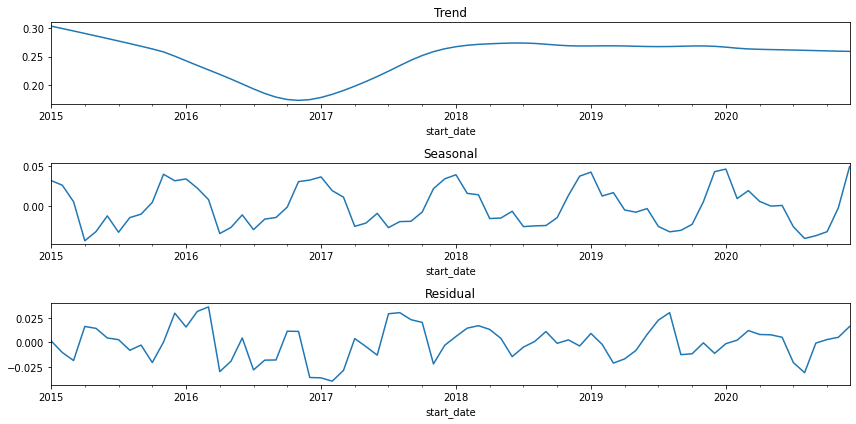

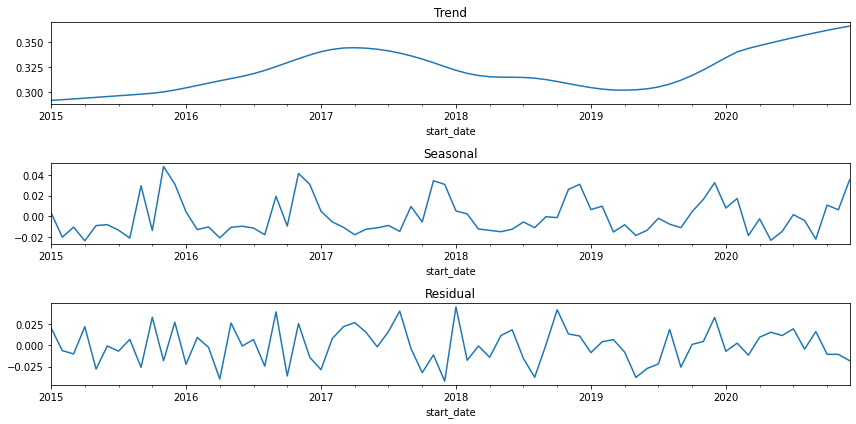

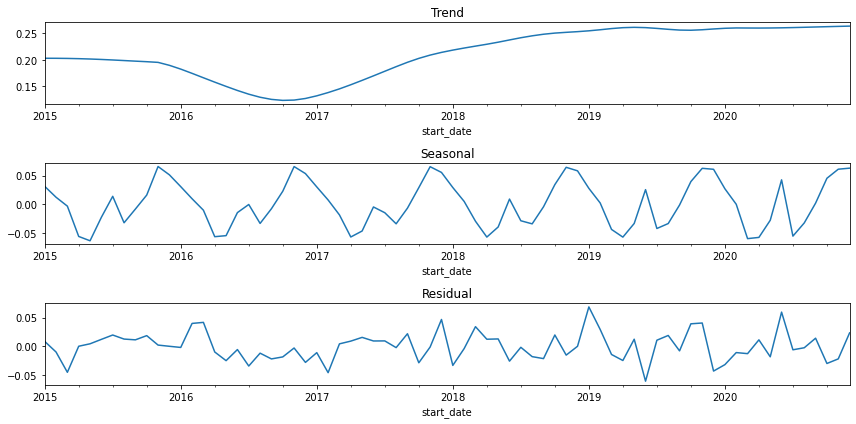

In [ ]:
decompose(new_df, 'smos')

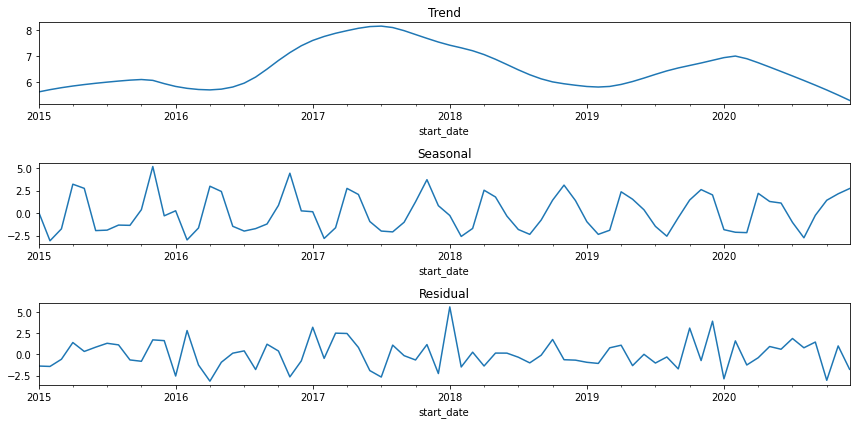

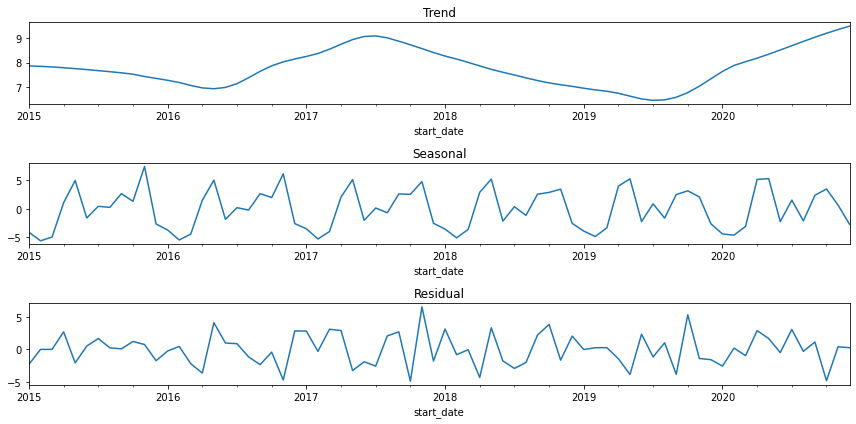

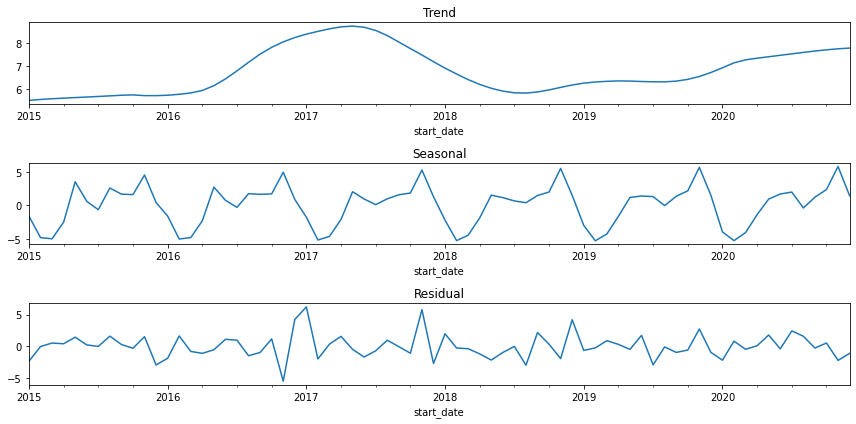

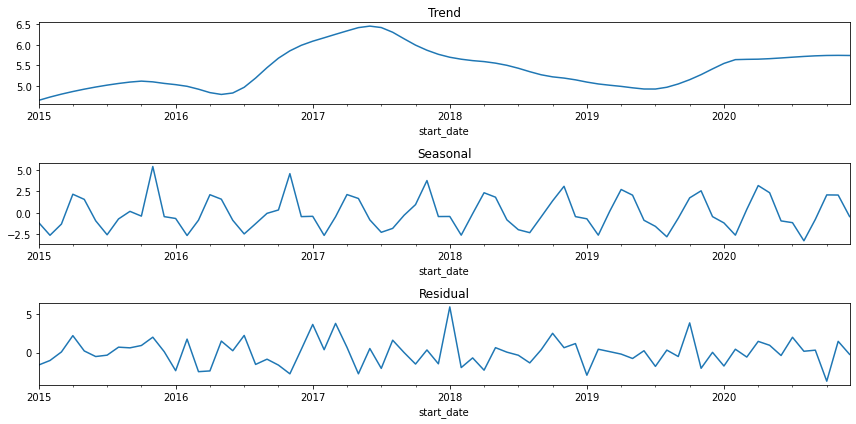

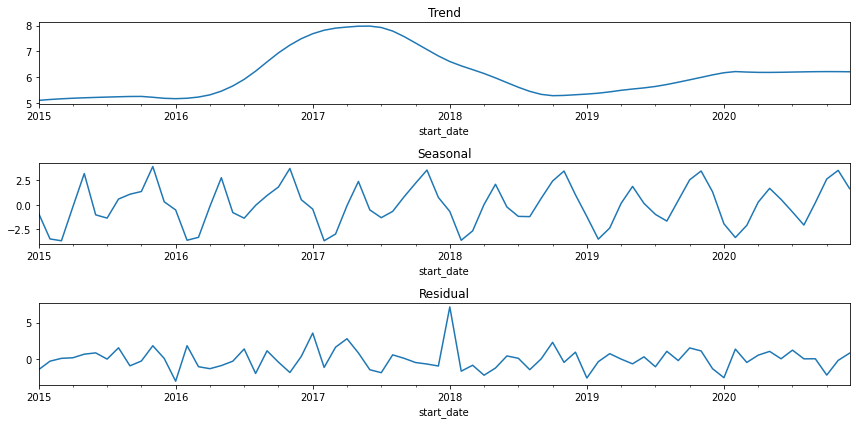

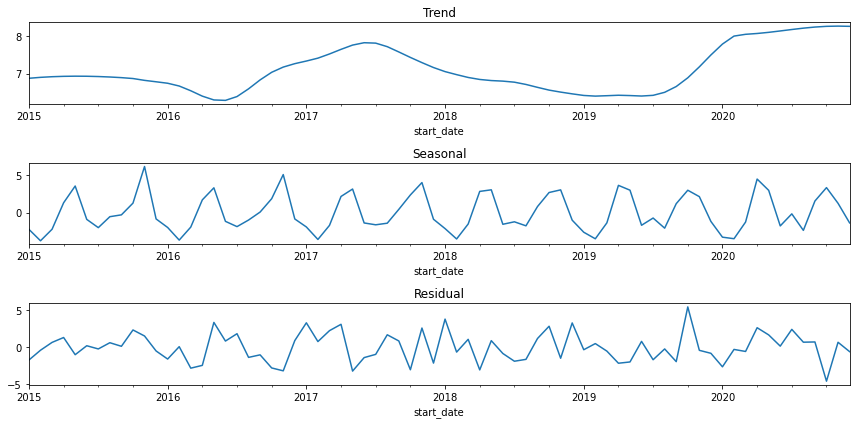

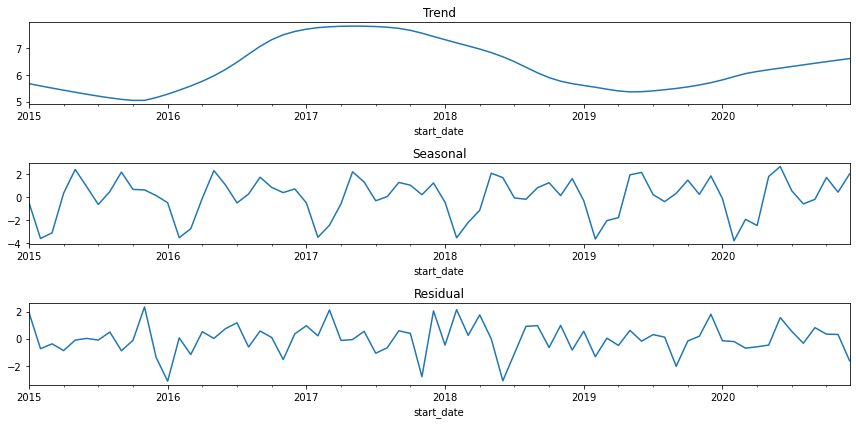

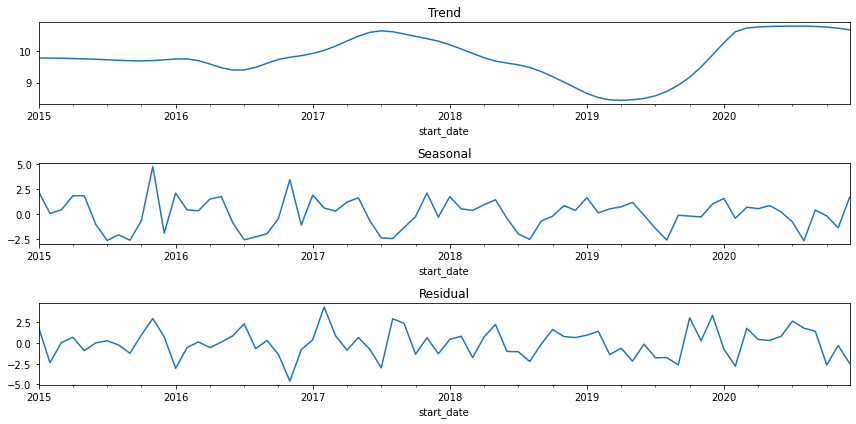

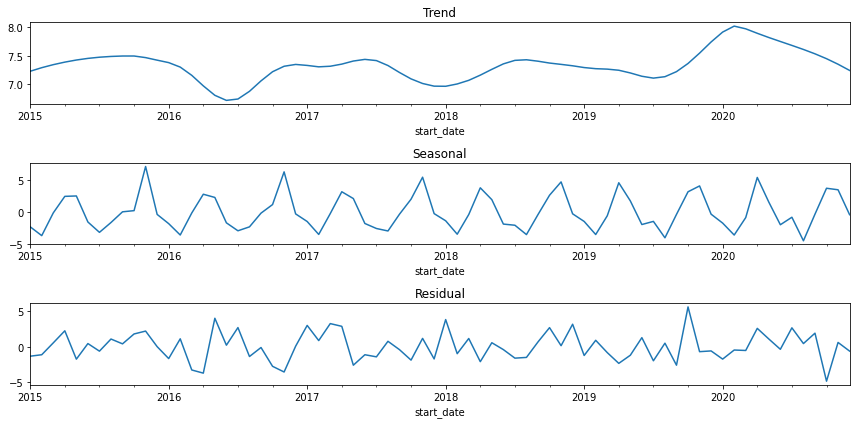

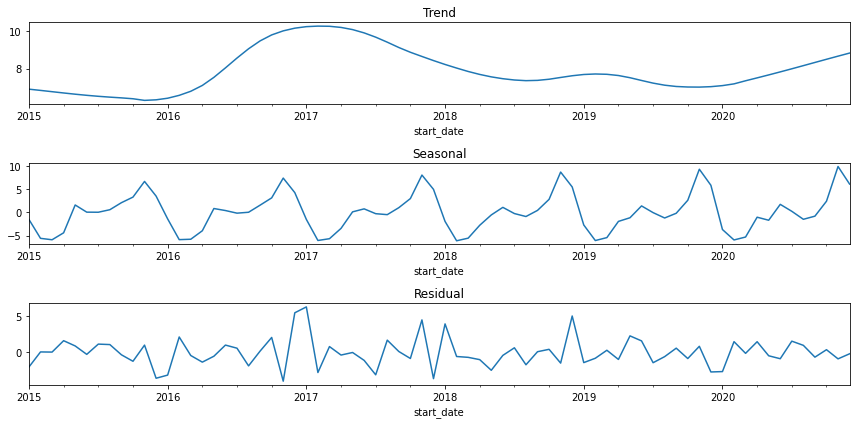

In [ ]:
decompose(new_df, 'precip')

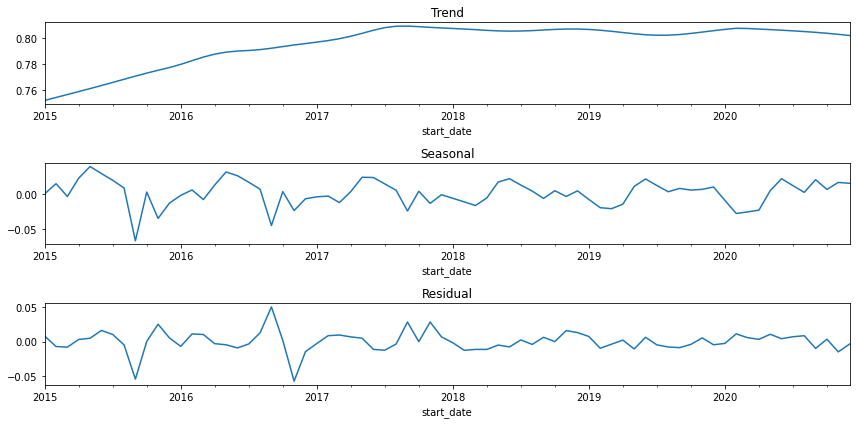

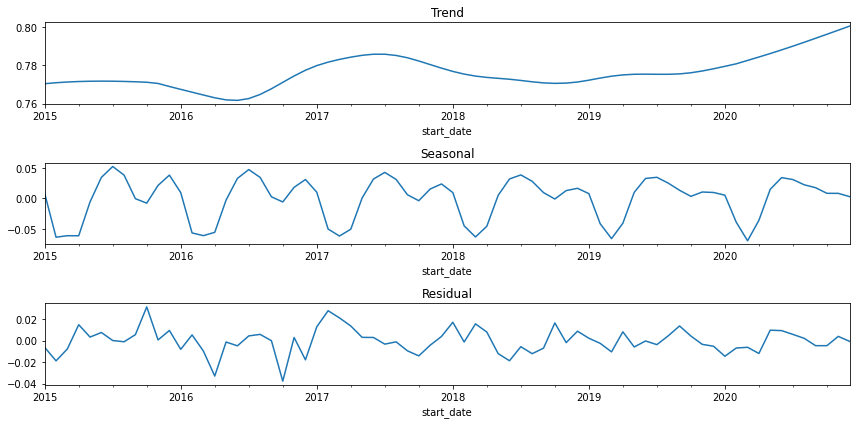

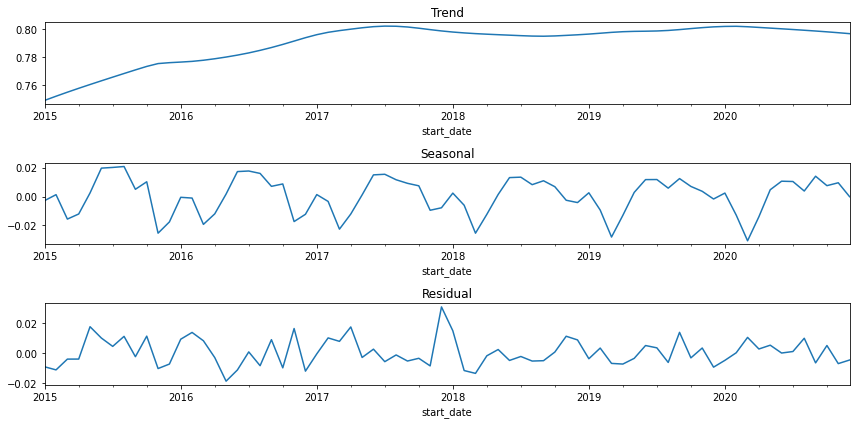

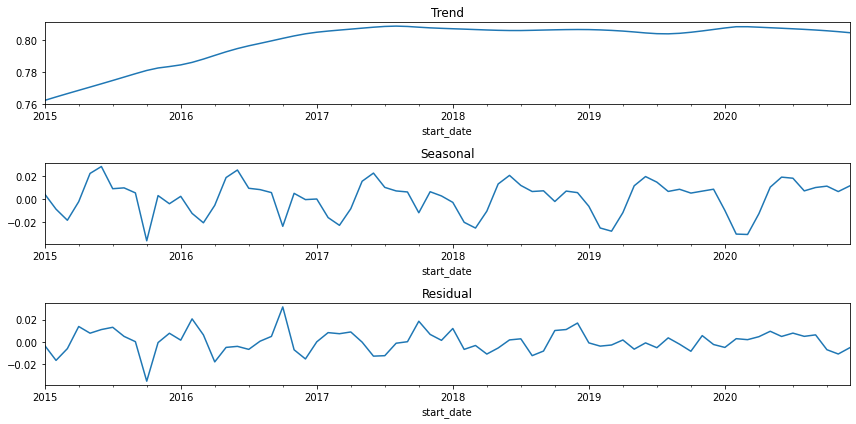

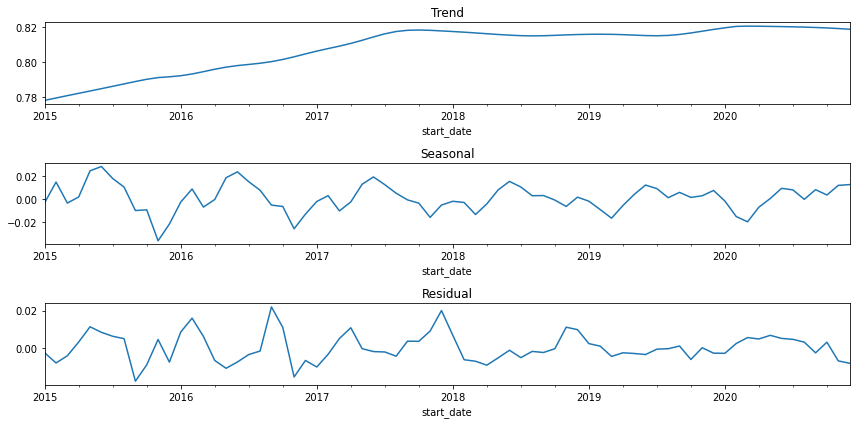

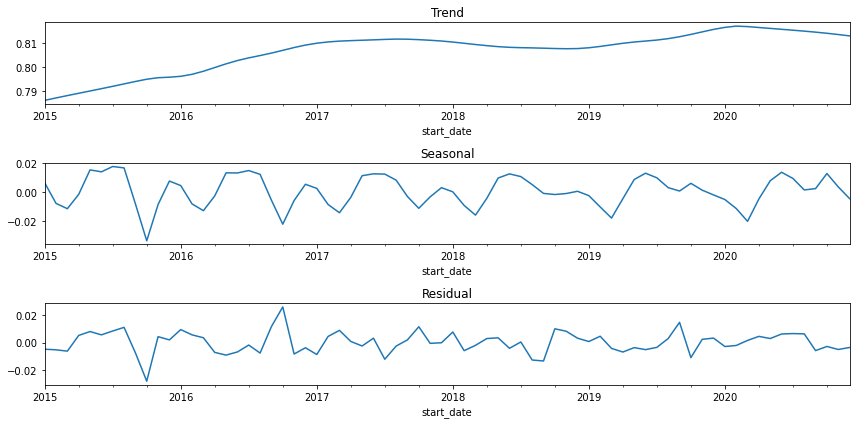

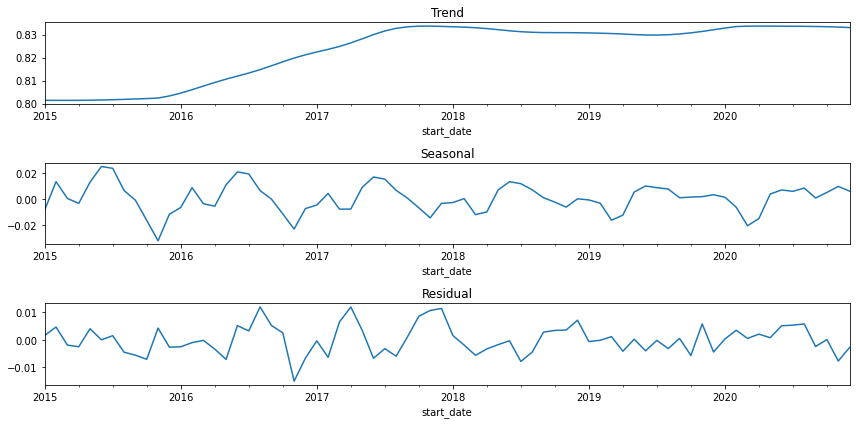

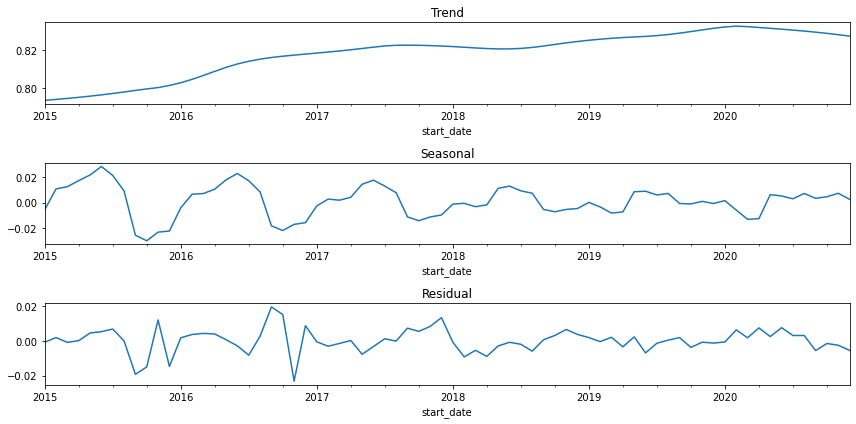

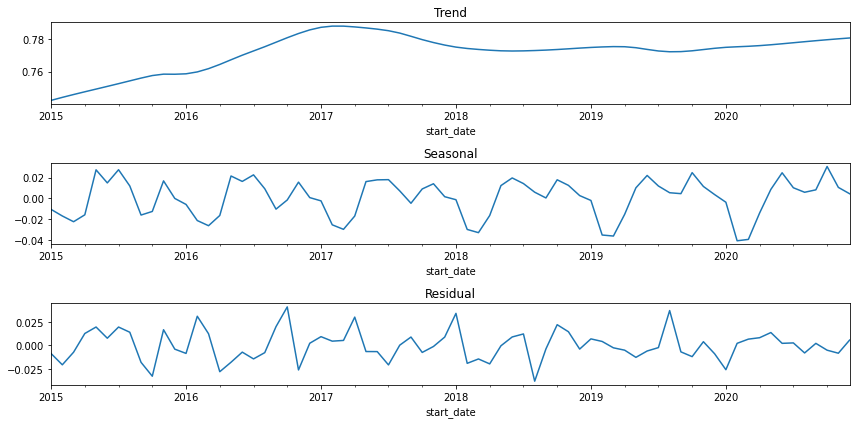

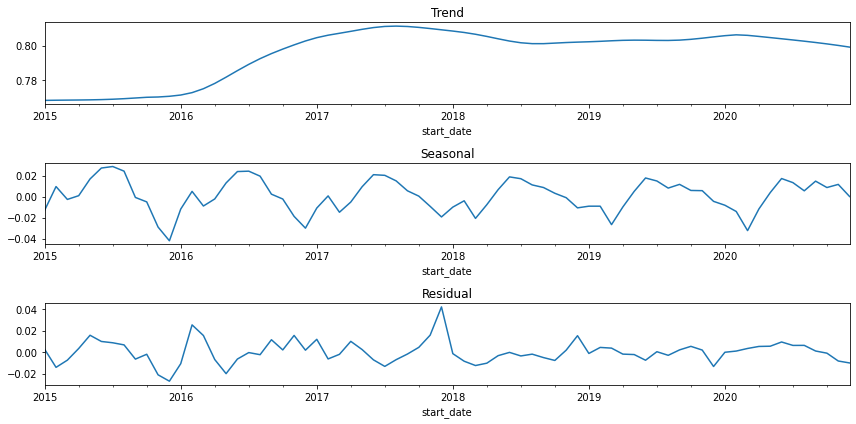

In [ ]:
decompose(new_df, 'ndvi')

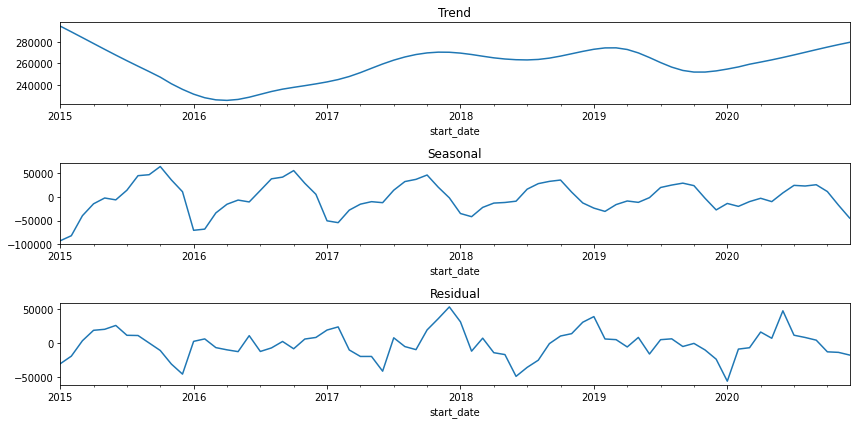

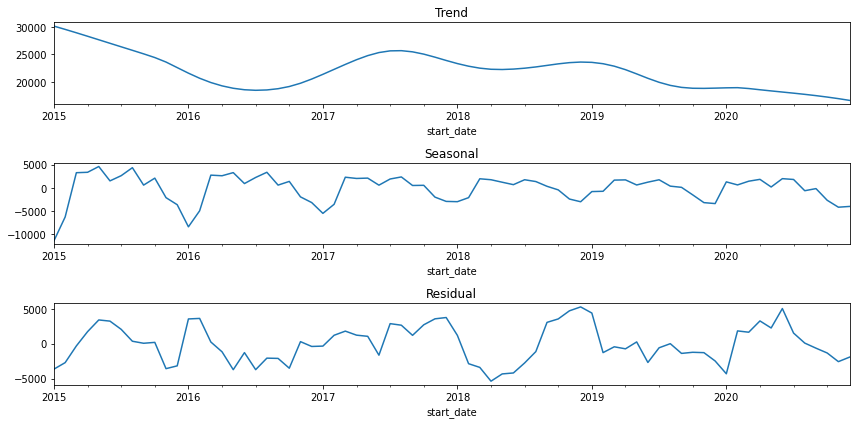

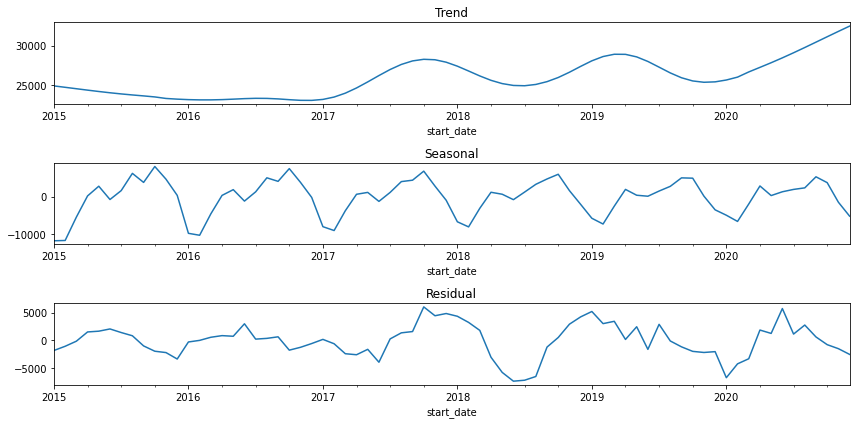

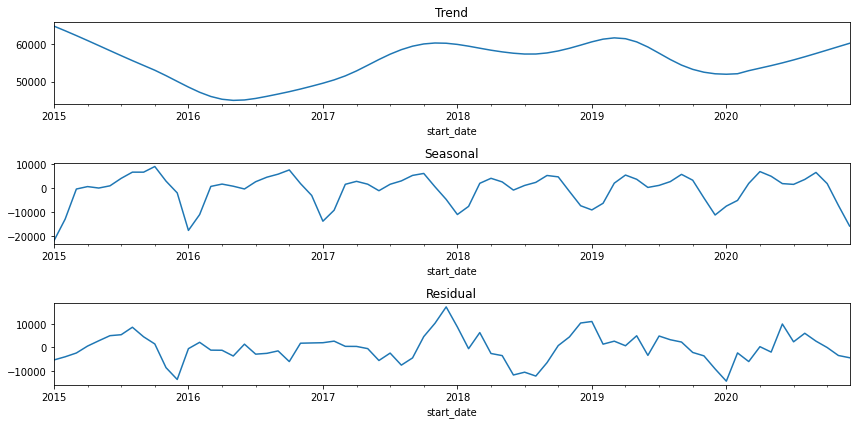

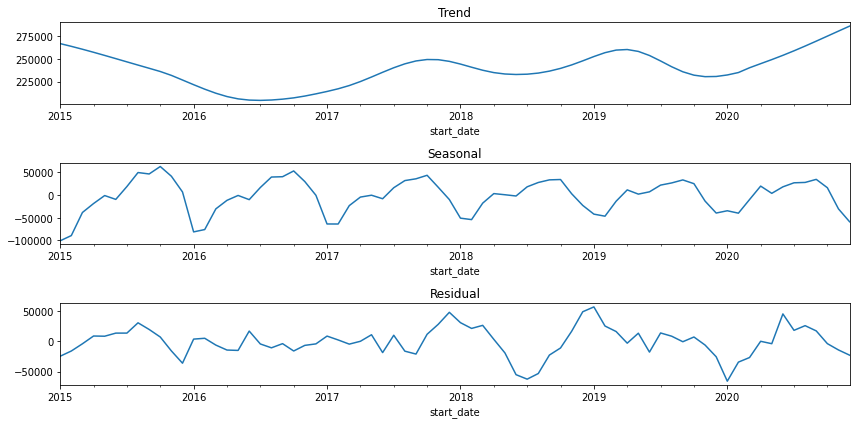

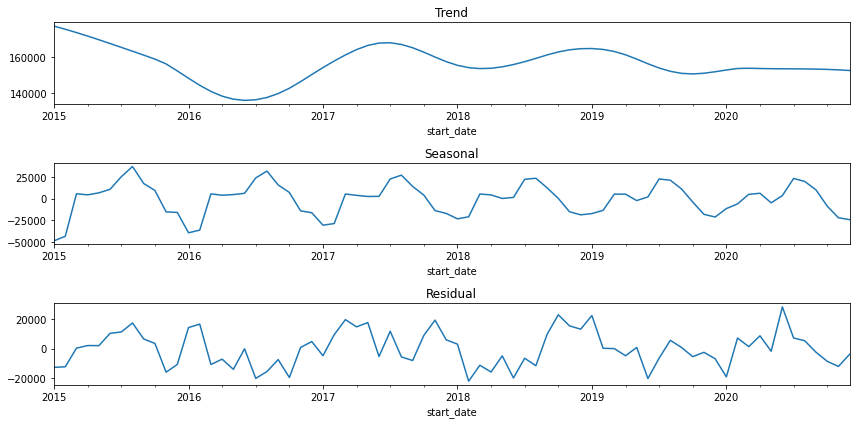

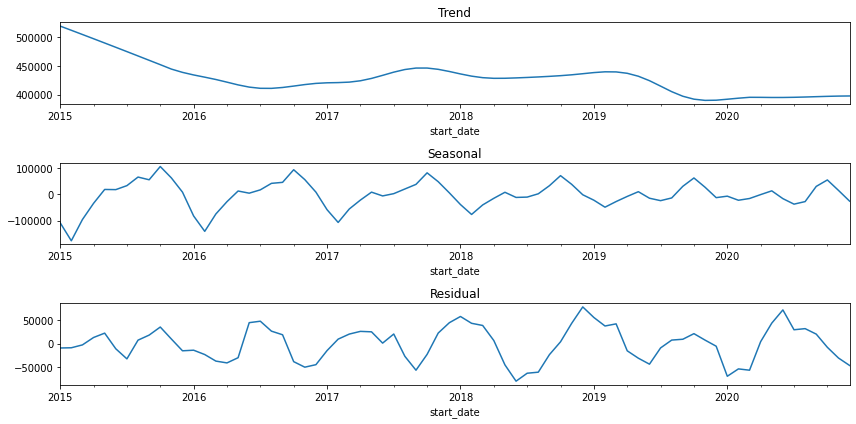

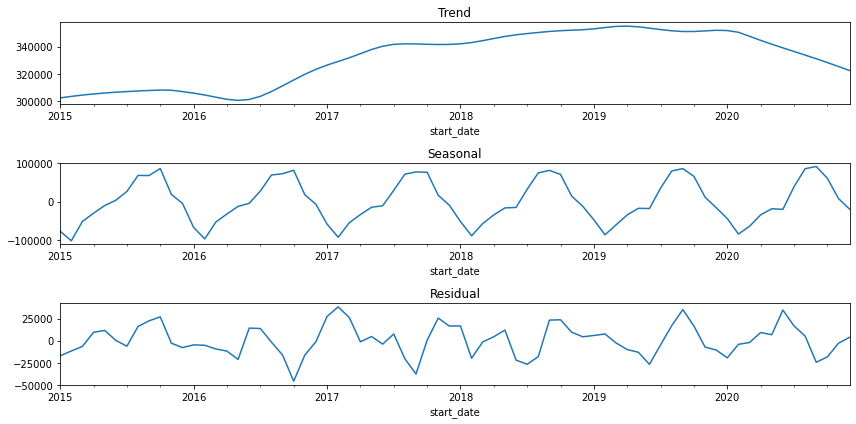

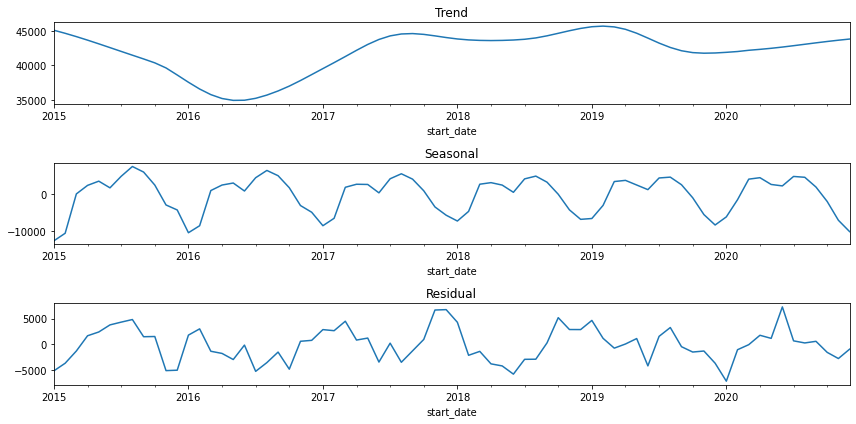

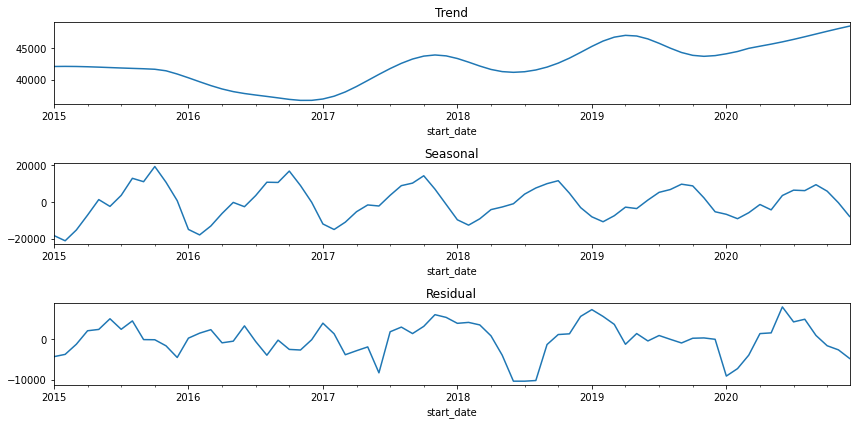

In [ ]:
decompose(new_df, 'prod')

### **Train Test Split**

In [ ]:
train_df = []
test_df = []

for i in range(len(new_df)):
    train_df.append(new_df[i][:-10])
    test_df.append(new_df[i][-10:])

train = pd.concat(train_df)
train.reset_index(drop=True, inplace=True)
test = pd.concat(test_df)
test.reset_index(drop=True, inplace=True)

In [ ]:
train.shape, test.shape

((620, 7), (100, 7))

### **Augmented Dickey–Fuller Test**

**The prod values for region 2, region 3, region 8 and region 10 are not stationary. This can be handled by differencing in before passing to SARIMAX**

In [ ]:
def adf_test(df,col):
    result = adfuller(df[col].values, autolag='AIC')
    p_value=result[1]
    if p_value <= 0.05:
        return True
    else:
        return False

### **SARIMAX with Auto ARIMA**

In [ ]:
def autoarima(train_X, train_y):

    step_wise=auto_arima(train_y, 
    exog=train_X,
    start_p=1, start_q=1, 
    max_p=3, max_q=3, 
    d=1, max_d=3, m=12,
    seasonal=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True)

    return step_wise.get_params()['order'], step_wise.get_params()['seasonal_order']

In [ ]:
train.set_index('end_date', inplace=True)
test.set_index('end_date', inplace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-50.781, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-46.552, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-53.926, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-52.251, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-48.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-47.201, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-52.048, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-52.318, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-51.636, Time=1.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-55.265, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-53.322, Time=0.33 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-53.384, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-53.339, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   

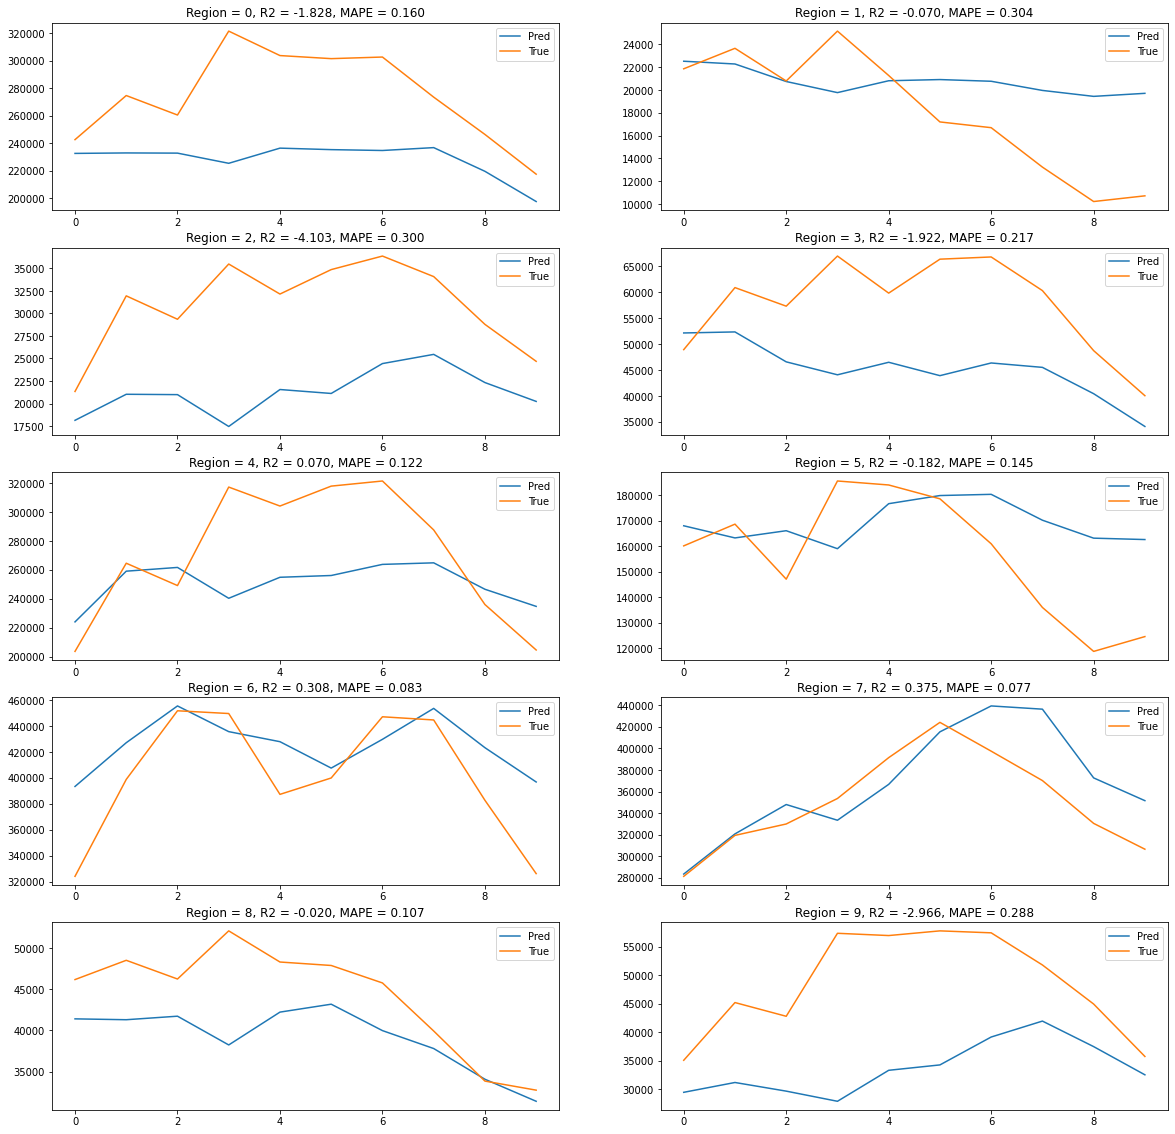

In [ ]:
# Train a separate model for each region

models = []
in_cols = ['precip', 'smos', 'temp', 'ndvi']
out_cols = ['prod']

num_regions = 10
num_train_per_region = 62
num_test_per_region = 10

plt.figure(figsize=(20, 20))

for i in range(num_regions):

    # train and test for the current region
    region_train = train.iloc[i*num_train_per_region:(i+1)*num_train_per_region]
    region_test = test.iloc[i*num_test_per_region:(i+1)*num_test_per_region]

    # Normalise train and test data
    sc_in = MinMaxScaler(feature_range=(0, 1))
    scaled_input = sc_in.fit_transform(region_train[in_cols])
    train_X = pd.DataFrame(scaled_input, columns=in_cols)
    train_X.index = region_train.index

    sc_out = MinMaxScaler(feature_range=(0, 1))
    scaled_output = sc_out.fit_transform(region_train[out_cols])
    train_y = pd.DataFrame(scaled_output, columns=out_cols)
    train_y.index = region_train.index

    scaled_test_input = sc_in.transform(region_test[in_cols])
    test_X = pd.DataFrame(scaled_test_input, columns=in_cols)
    test_X.index = region_test.index
        
    o,so=autoarima(train_X, train_y)

    # Fit SARIMAX model
    model = sm.tsa.statespace.SARIMAX(train_y, exog=train_X, order=o, seasonal_order=so)
    fit_res = model.fit(disp=False)

    # Forcast for num_test_per_region samples
    forecast = fit_res.forecast(steps = num_test_per_region, exog = test_X)

    # Invert normalisation on pred
    pred = sc_out.inverse_transform(forecast.values.reshape(-1, 1))
    true = region_test[out_cols].values

    # Calculate metrics
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(pred, true))
    mape = sklearn.metrics.mean_absolute_percentage_error(true, pred)
    r2 = sklearn.metrics.r2_score(true, pred)

    # plot curves
    plt.subplot(5, 2, i+1)
    plt.plot(pred)
    plt.plot(true)
    plt.legend(['Pred', 'True'])
    plt.title('Region = {}, R2 = {:.3f}, MAPE = {:.3f}'.format(i, r2, mape))

    # Save fit results
    models.append(fit_res)

plt.show()

In [ ]:
#merging data for 2021
p=daily_percipitation.loc[(daily_percipitation.start_date >='2020') & (daily_percipitation.start_date < '2022')]
s=daily_soil_moisture.loc[(daily_soil_moisture.start_date >='2020') & (daily_soil_moisture.start_date < '2022')]
t=daily_temperature.loc[(daily_temperature.start_date >='2020') & (daily_temperature.start_date < '2022')]
n=ndvi_2021.loc[(ndvi_2021.start_date >='2020') & (ndvi_2021.start_date < '2022')]

merged=merge(p,s,t,n)
merged[0].head()

end_date    precip  region_id      smos       temp  \
0 2020-01-31 00:00:00+00:00  2.213455       93.0  0.349116  27.369525   
1 2020-02-29 00:00:00+00:00  6.460553       93.0  0.344122  28.043803   
2 2020-03-31 00:00:00+00:00  3.473772       93.0  0.327839  29.555205   
3 2020-04-30 00:00:00+00:00  8.552903       93.0  0.332118  29.642767   
4 2020-05-31 00:00:00+00:00  8.801806       93.0  0.357866  27.966113   

       ndvi  
0  0.795000  
1  0.790950  
2  0.787593  
3  0.787232  
4  0.821790

In [ ]:
#train on all samples for each region
models = []
pred_2021=[]

for idx_region,df in enumerate(new_df):
    train_df = df.set_index('end_date')

    sc_in = MinMaxScaler(feature_range=(0, 1))
    scaled_input = sc_in.fit_transform(train_df[in_cols])
    train_X = pd.DataFrame(scaled_input, columns=in_cols)
    train_X.index = train_df.index

    sc_out = MinMaxScaler(feature_range=(0, 1))
    scaled_output = sc_out.fit_transform(train_df[out_cols])
    train_y = pd.DataFrame(scaled_output, columns=out_cols)
    train_y.index = train_df.index

    o,so=autoarima(train_X, train_y)

    model = sm.tsa.statespace.SARIMAX(train_y, exog=train_X, order=o, seasonal_order=so)
    fit_res = model.fit(disp=False)

    models.append(fit_res)

    # find X values for year 2021
    test_2021= merged[idx_region].set_index('end_date')
    exog=test_2021[in_cols]

    scaled_test_input = sc_in.transform(exog)
    exog_2021 = pd.DataFrame(scaled_test_input, columns=in_cols)
    exog_2021.index = exog.index
    forecast=(fit_res.forecast(steps = 24, exog = exog_2021))

    pred_2021.append(sc_out.inverse_transform(forecast.values.reshape(-1, 1)))


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-55.974, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-54.277, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-59.694, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-58.790, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-56.238, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-54.562, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-57.840, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-57.802, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-58.856, Time=0.25 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-55.850, Time=0.97 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-61.621, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-59.774, Time=0.42 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-59.736, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-60.547, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercep

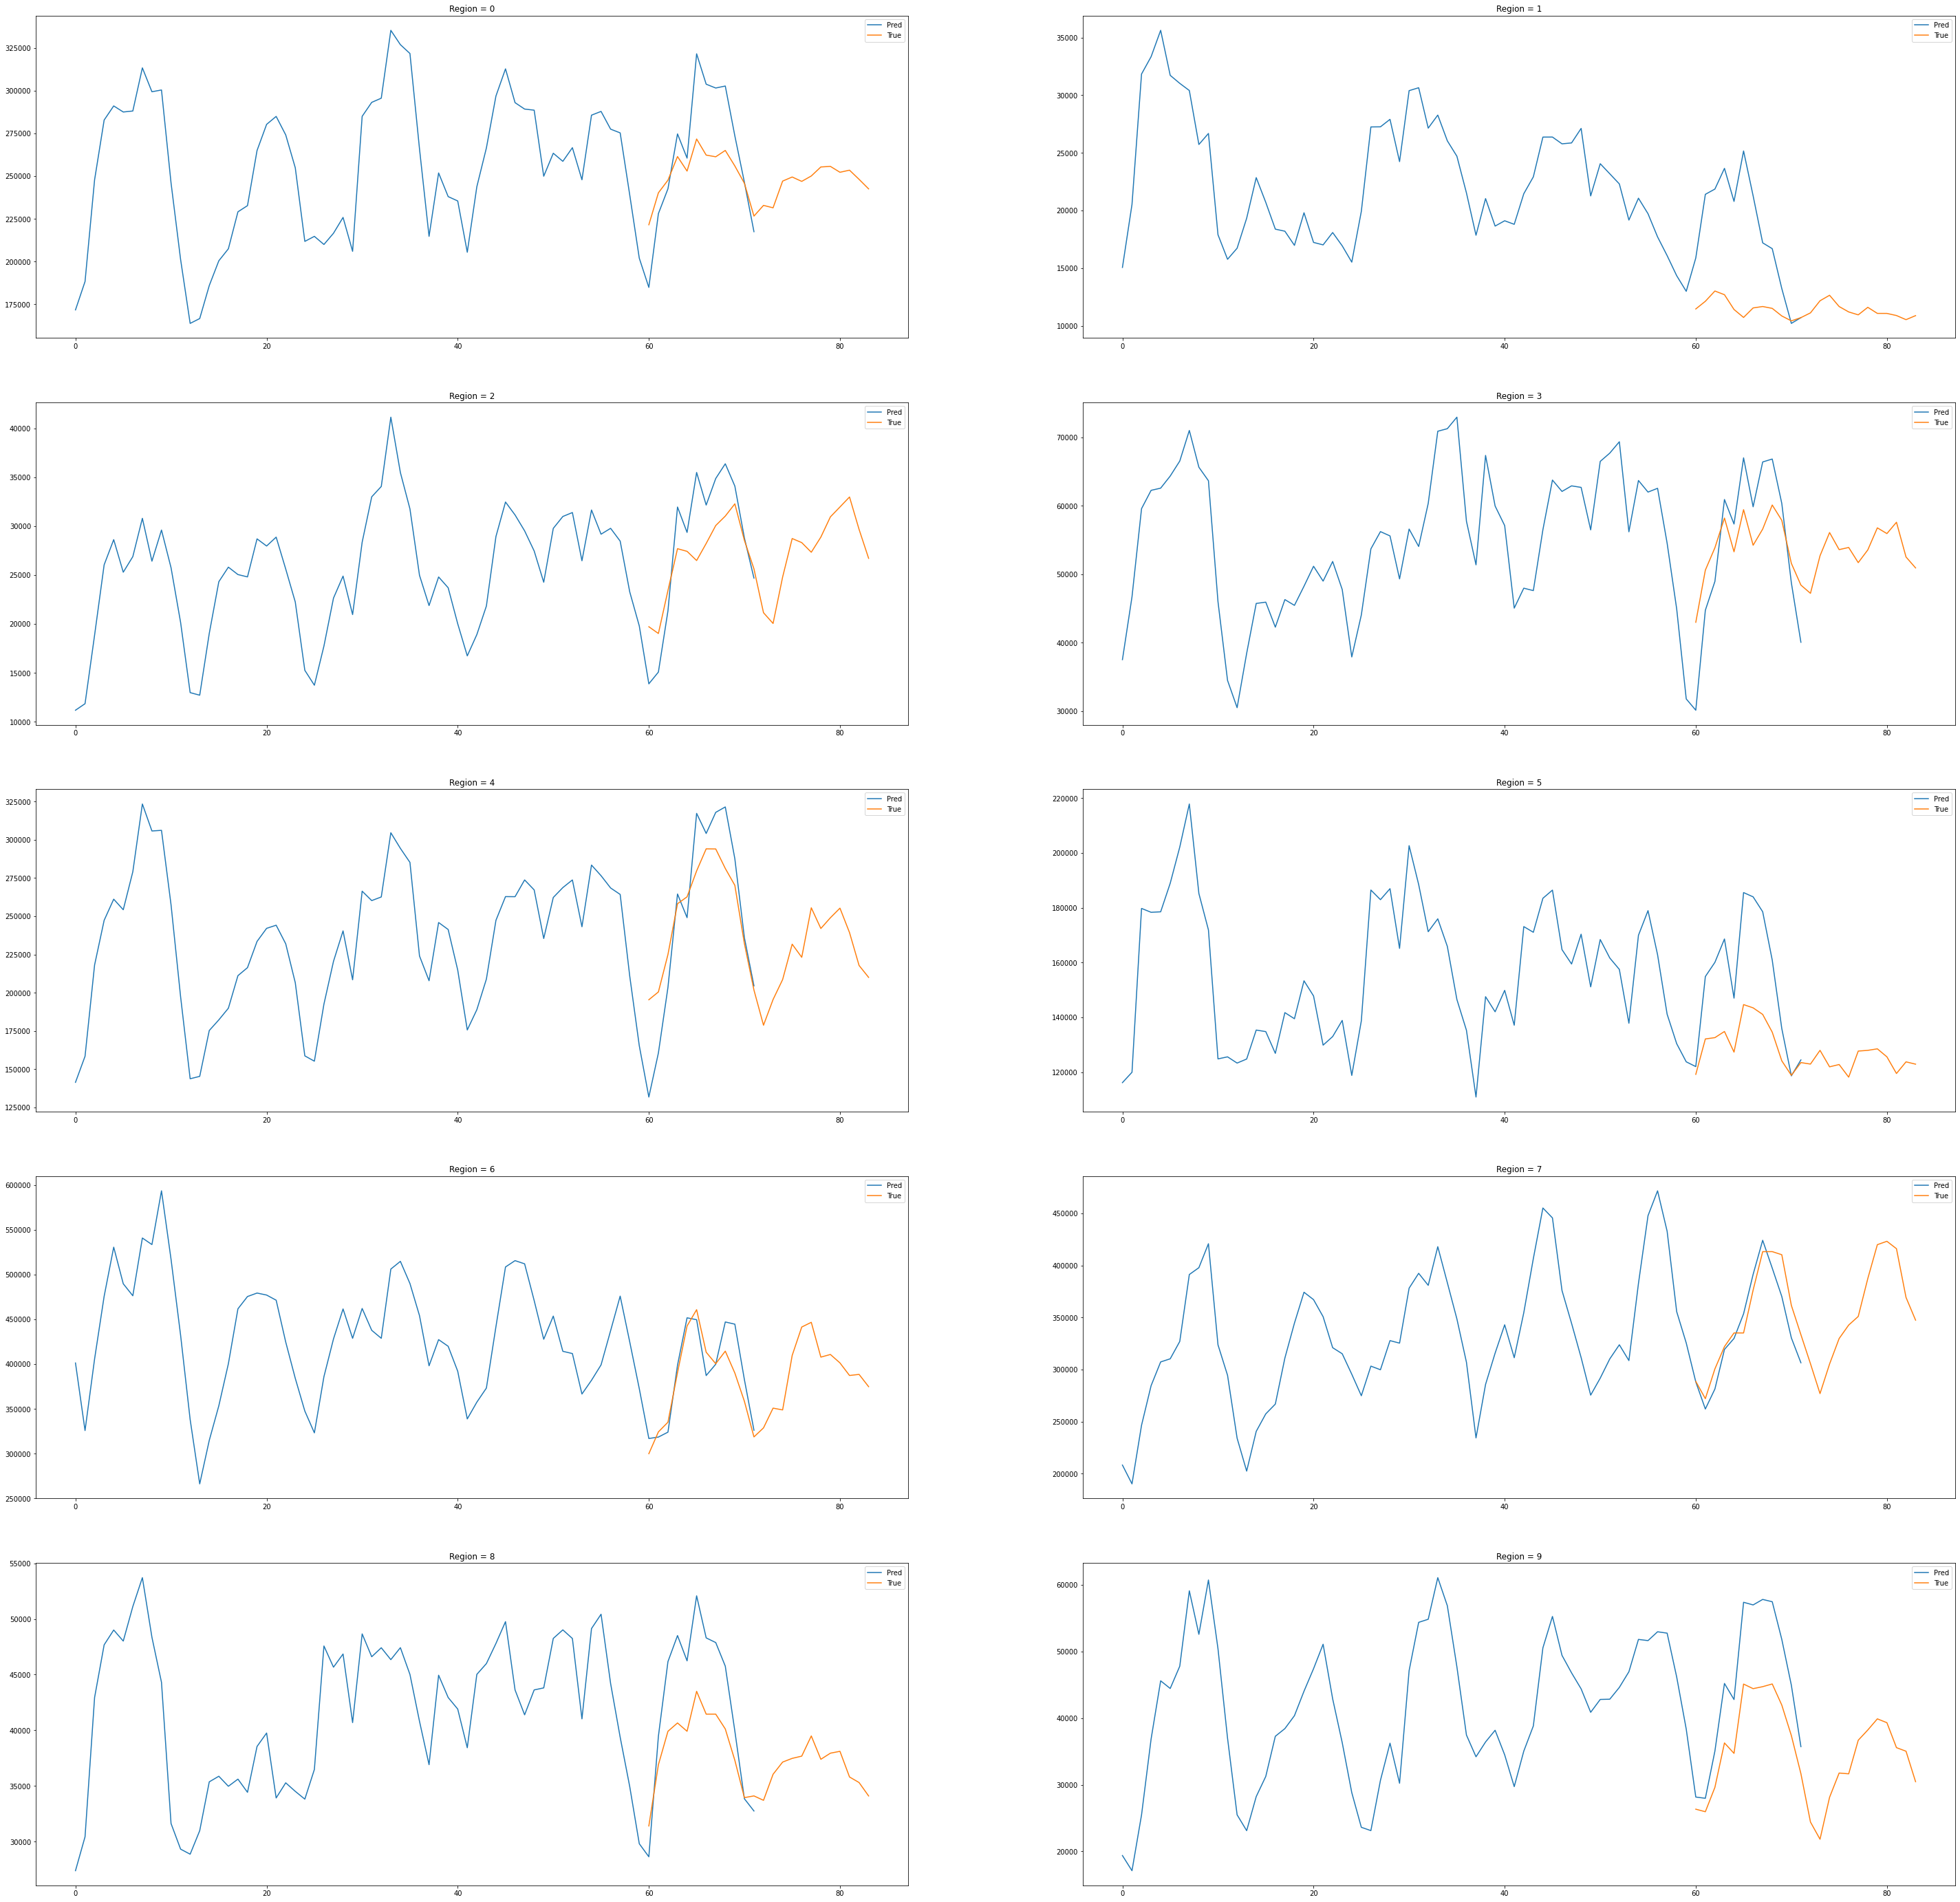

In [ ]:
#plots of prediction and previous production 

plt.figure(figsize=(50,50))
for i,p in enumerate(pred_2021):
    true=new_df[i]['prod'].values
    plt.subplot(5, 2, i+1)
    plt.plot(true)
    plt.plot(np.arange(60,84,1),p)
    plt.legend(['Pred', 'True'])
    plt.title('Region = {}'.format(i))
plt.show()

In [ ]:
prod_quantity=[]
for i in range(10):
    prod_quantity.append(pred_2021[i][12:])
prod_quantity_2021=np.concatenate(prod_quantity)

In [ ]:
predicted_production_quantity['prod']=prod_quantity_2021

In [ ]:
predicted_production_quantity

start_date                  end_date           prod  \
0    2021-01-01T00:00:00.000Z  2021-01-31T00:00:00.000Z  232872.106629   
1    2021-02-01T00:00:00.000Z  2021-02-28T00:00:00.000Z  231448.929841   
2    2021-03-01T00:00:00.000Z  2021-03-31T00:00:00.000Z  247071.492549   
3    2021-04-01T00:00:00.000Z  2021-04-30T00:00:00.000Z  249474.551588   
4    2021-05-01T00:00:00.000Z  2021-05-31T00:00:00.000Z  246913.151416   
..                        ...                       ...            ...   
115  2021-08-01T00:00:00.000Z  2021-08-31T00:00:00.000Z   39894.627484   
116  2021-09-01T00:00:00.000Z  2021-09-30T00:00:00.000Z   39318.690297   
117  2021-10-01T00:00:00.000Z  2021-10-31T00:00:00.000Z   35575.523092   
118  2021-11-01T00:00:00.000Z  2021-11-30T00:00:00.000Z   35037.559177   
119  2021-12-01T00:00:00.000Z  2021-12-31T00:00:00.000Z   30464.001128   

     region_id  
0           93  
1           93  
2           93  
3           93  
4           93  
..         ...  
115        105  
116        105  
117        105  
118        105  
119        105  

[120 rows x 4 columns]

In [ ]:
# predicted_production_quantity.to_csv('nithyash@usc.edu.csv')